# 1.Peparing function
In this section, we will prepare the necessary preprocessing steps and implement the recommendation function itself.

In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Sparse Matrix and Cosine Similarity
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Scaling and Preprocessing
from sklearn.preprocessing import MinMaxScaler

In [ ]:


tracks_df = pd.read_csv('/content/drive/MyDrive/Spotify_Recommendation_Engine/PREPROCESSED_DATA/DATA_preprocessed.csv')
listening_history_df = pd.read_csv('/content/drive/MyDrive/Spotify_Recommendation_Engine/PREPROCESSED_DATA/User Listening History.csv')


Turning id's to category type to reduce memory usage

In [ ]:
listening_history_df['user_id'] = listening_history_df['user_id'].astype('category')
listening_history_df['track_id'] = listening_history_df['track_id'].astype('category')

In [ ]:
listening_history_df

,track_id,user_id,playcount
0,TRIRLYL128F42539D1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
1,TRFUPBA128F934F7E1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
2,TRLQPQJ128F42AA94F,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
3,TRTUCUY128F92E1D24,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
4,TRHDDQG12903CB53EE,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
...,...,...,...
9711296,TRBKFKL128E078ED76,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1
9711297,TRYFXPG128E078ECBD,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1
9711298,TROBUUZ128F4263002,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1
9711299,TROEWXC128F148C83E,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1


Creating a sparse matrix of tracks, users, and play counts

In [ ]:

user_item_sparse_matrix = csr_matrix((
    listening_history_df['playcount'].values,
    (
        listening_history_df['user_id'].cat.codes,
        listening_history_df['track_id'].cat.codes
    )
))

In [ ]:

user_mapper = dict(enumerate(listening_history_df['user_id'].cat.categories))
track_mapper = dict(enumerate(listening_history_df['track_id'].cat.categories))
user_inv_mapper = {v: k for k, v in user_mapper.items()}
track_inv_mapper = {v: k for k, v in track_mapper.items()}


Computing the track similarity matrix using cosine similarity

In [ ]:
track_similarity_sparse = cosine_similarity(user_item_sparse_matrix.T, dense_output=False)

Here is sample of our matrix,

**X axis track_id**

**Y axis track_id**

The closer the value is to 1, the more similar the tracks are; the closer it is to 0, the more dissimilar they are. Keep in mind that these values are derived from the cosine function, which can cause the results to quickly approach either 1 or 0 due to its slope behavior.



In [ ]:
print(track_similarity_sparse[:5, :5].toarray())


[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


At this point, we can officially declare our recommendation function, the heart of our system.

In [ ]:

# Function to generate recommendations
def hybrid_recommend(user_id, top_n=10, genre_weight=0.2, artist_weight=0.1, content_weight=0.7):
    # Get the user's listening history with playcounts
    user_history = listening_history_df[listening_history_df['user_id'] == user_id]
    if user_history.empty:
        return pd.DataFrame()

    # Merge listening history with track features
    user_history = user_history.merge(tracks_df, on='track_id')
    numerical_features = ['danceability', 'energy', 'loudness', 'speechiness',
                          'acousticness', 'instrumentalness', 'liveness', 'valence',
                          'tempo', 'duration_s']

    # Calculate weighted average of features for the user's most-played tracks
    weighted_features = (user_history[numerical_features].T * user_history['playcount']).T.sum() / user_history['playcount'].sum()

    # Content-Based Filtering
    track_features = tracks_df.set_index('track_id')[numerical_features]
    content_sim = cosine_similarity([weighted_features], track_features)[0]
    content_similar_tracks = pd.Series(content_sim, index=track_features.index)

    # Collaborative Filtering
    user_track_indices = [track_inv_mapper[track] for track in user_history['track_id'] if track in track_inv_mapper]
    user_similar_tracks = pd.Series(dtype=float)
    for idx in user_track_indices:
        user_similar_tracks = user_similar_tracks.add(
            pd.Series(track_similarity_sparse[idx].toarray().flatten(), index=list(track_mapper.values())),
            fill_value=0
        )
    user_similar_tracks = user_similar_tracks.sort_values(ascending=False)

    # Genre and Artist Scores
    top_genres = user_history.groupby('genre')['playcount'].sum().sort_values(ascending=False).index[:3]
    top_artists = user_history.groupby('artist')['playcount'].sum().sort_values(ascending=False).index[:3]

    genre_similar_tracks = tracks_df['genre'].apply(lambda x: 1 if x in top_genres else 0)
    artist_similar_tracks = tracks_df['artist'].apply(lambda x: 1 if x in top_artists else 0)

    genre_similar_tracks = pd.Series(genre_similar_tracks.values, index=tracks_df['track_id'])
    artist_similar_tracks = pd.Series(artist_similar_tracks.values, index=tracks_df['track_id'])

    # Combine all scores with specified weights
    combined_scores = (
        content_similar_tracks * content_weight +
        user_similar_tracks.reindex(tracks_df['track_id']).fillna(0) * (1 - content_weight) +
        genre_similar_tracks * genre_weight +
        artist_similar_tracks * artist_weight
    )

    # Sort and select the top N recommendations
    combined_recommendations = combined_scores.sort_values(ascending=False).head(top_n)
    recommended_track_ids = combined_recommendations.index.tolist()

    # Fetch recommended track features for output
    recommended_tracks = tracks_df[tracks_df['track_id'].isin(recommended_track_ids)]

    return recommended_tracks[['track_id', 'name', 'artist', 'genre', 'danceability', 'energy', 'valence',
                               'tempo', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
                               'liveness', 'duration_s']]


Now, we will determine the optimal weights for our recommendation function. Our goal is to minimize the differences between historical and recommended tracks.

We will iterate over 66 combinations.

In [ ]:

#Generate weight combinations
weight_combinations = []
for genre_weight in np.arange(0, 1.1, 0.1):
    for artist_weight in np.arange(0, 1.1, 0.1):
        content_weight = 1 - (genre_weight + artist_weight)
        if content_weight >= 0:
            weight_combinations.append((genre_weight, artist_weight, content_weight))

#Randomly select 100 users
random_users = listening_history_df['user_id'].drop_duplicates().sample(100).tolist()
numerical_features = ['danceability', 'energy', 'loudness', 'speechiness',
                      'acousticness', 'instrumentalness', 'liveness', 'valence',
                      'tempo', 'duration_s']
features_to_scale = ['loudness', 'tempo', 'duration_s']

features_num=len(numerical_features)

In [ ]:

scaler = MinMaxScaler()
#Evaluate recommendations for all weight combinations
results = []

for weights in weight_combinations:
    genre_weight, artist_weight, content_weight = weights

    # Printing the current weight set for progress tracking
    print(f"Evaluating weights: Genre={genre_weight:.1f}, Artist={artist_weight:.1f}, Content={content_weight:.1f}")

    total_feature_diff = 0
    total_genre_diff = 0
    user_count = 0

    for user_id in random_users:
        # Get recommendations
        recommended_tracks = hybrid_recommend(user_id, top_n=10,
                                              genre_weight=genre_weight,
                                              artist_weight=artist_weight,
                                              content_weight=content_weight)
        user_history = listening_history_df[listening_history_df['user_id'] == user_id]
        user_history = user_history.merge(tracks_df, on='track_id')

        if recommended_tracks.empty or user_history.empty:
            continue

        # HERE
        user_history[features_to_scale] = scaler.fit_transform(user_history[features_to_scale])
        recommended_tracks[features_to_scale] = scaler.transform(recommended_tracks[features_to_scale])

        # Calculate cumulative stats for numerical features
        hist_features = user_history[numerical_features].mean()
        rec_features = recommended_tracks[numerical_features].mean()

        # Calculate genre distributions
        hist_genre_dist = user_history['genre'].value_counts(normalize=True)
        rec_genre_dist = recommended_tracks['genre'].value_counts(normalize=True)

        # Align genre distributions
        all_genres = set(hist_genre_dist.index).union(set(rec_genre_dist.index))
        hist_genre_dist = hist_genre_dist.reindex(all_genres, fill_value=0)
        rec_genre_dist = rec_genre_dist.reindex(all_genres, fill_value=0)

        # Calculate differences
        feature_diff = np.abs(hist_features - rec_features).sum()
        genre_diff = np.abs(hist_genre_dist - rec_genre_dist).sum()

        genre_diff = genre_diff * features_num

        # Accumulate differences
        total_feature_diff += feature_diff
        total_genre_diff += genre_diff
        user_count += 1

    # Average the differences over users
    avg_feature_diff = total_feature_diff / user_count if user_count > 0 else np.inf
    avg_genre_diff = total_genre_diff / user_count if user_count > 0 else np.inf
    total_diff = avg_feature_diff + avg_genre_diff

    # Append results
    results.append({
        'genre_weight': genre_weight,
        'artist_weight': artist_weight,
        'content_weight': content_weight,
        'avg_feature_diff': avg_feature_diff,
        'avg_genre_diff': avg_genre_diff,
        'total_diff': total_diff
    })

results_df = pd.DataFrame(results)

# Find the best weight combination
best_result = results_df.sort_values(by='total_diff').iloc[0]
print("Best Weights Across All Users:")
print(best_result)

# Show 10 best weight combinations
print("\nTop 10 Best Weights:")
print(results_df.sort_values(by='total_diff').head(10))


Evaluating weights: Genre=0.0, Artist=0.0, Content=1.0
Evaluating weights: Genre=0.0, Artist=0.1, Content=0.9
Evaluating weights: Genre=0.0, Artist=0.2, Content=0.8
Evaluating weights: Genre=0.0, Artist=0.3, Content=0.7
Evaluating weights: Genre=0.0, Artist=0.4, Content=0.6
Evaluating weights: Genre=0.0, Artist=0.5, Content=0.5
Evaluating weights: Genre=0.0, Artist=0.6, Content=0.4
Evaluating weights: Genre=0.0, Artist=0.7, Content=0.3
Evaluating weights: Genre=0.0, Artist=0.8, Content=0.2
Evaluating weights: Genre=0.0, Artist=0.9, Content=0.1
Evaluating weights: Genre=0.0, Artist=1.0, Content=0.0
Evaluating weights: Genre=0.1, Artist=0.0, Content=0.9
Evaluating weights: Genre=0.1, Artist=0.1, Content=0.8
Evaluating weights: Genre=0.1, Artist=0.2, Content=0.7
Evaluating weights: Genre=0.1, Artist=0.3, Content=0.6
Evaluating weights: Genre=0.1, Artist=0.4, Content=0.5
Evaluating weights: Genre=0.1, Artist=0.5, Content=0.4
Evaluating weights: Genre=0.1, Artist=0.6, Content=0.3
Evaluating

All Top 10 weights have one thing in common, high content_weight.

In [ ]:
results_df_best=results_df.sort_values(by='total_diff').head(10)

In [ ]:
results_df_best

,genre_weight,artist_weight,content_weight,avg_feature_diff,avg_genre_diff,total_diff
21,0.2,0.0,0.8,6.322968,3.253093,9.576060
11,0.1,0.0,0.9,6.393024,3.274608,9.667631
30,0.3,0.0,0.7,6.978277,3.258143,10.236420
12,0.1,0.1,0.8,6.905603,3.503800,10.409402
38,0.4,0.0,0.6,7.343515,3.305643,10.649158
22,0.2,0.1,0.7,7.440845,3.320466,10.761312
45,0.5,0.0,0.5,7.619394,3.298976,10.918370
31,0.3,0.1,0.6,7.838811,3.302642,11.141453
64,0.9,0.1,0.0,8.168786,3.401199,11.569985
51,0.6,0.0,0.4,8.391877,3.278976,11.670854


In [ ]:
# Calculate the average of each column
averages = results_df_best[['genre_weight', 'artist_weight', 'content_weight']].mean(axis=0)

print("Average Weights Across Columns:")
print(f"Genre Weight: {averages['genre_weight']:.2f}")
print(f"Artist Weight: {averages['artist_weight']:.2f}")
print(f"Content Weight: {averages['content_weight']:.2f}")


Average Weights Across Columns:
Genre Weight: 0.36
Artist Weight: 0.04
Content Weight: 0.60


We will set final weights like this

content_weight-0.7

artist_weight-0.1

genre_weight-0.2

This are most optimal weights, for broader amount of users. They should make us able recommend mostly tracks that are similar to user's listening history, but also introduce some noise, novelty that can give user something new.

# 2.Plotting recommendation results

We will recommend tracks for 100 random users. By examining the recommendations, we can assess whether our function is performing correctly.

In [ ]:

random_user_ids = random.sample(list(listening_history_df['user_id'].unique()), 100)

# Initialize lists to collect genres, user IDs, and track IDs
all_recommended_genres = []
all_history_genres = []
user_track_recommendations = []  # Store user ID and track ID pairs for recommendations


In [ ]:

# Select 100 random user IDs
random_user_ids = random.sample(list(listening_history_df['user_id'].unique()), 100)

# Initialize lists to collect genres, user IDs, and track IDs
all_recommended_genres = []
all_history_genres = []
user_track_recommendations = []  # Store user ID and track ID pairs for recommendations

# Loop through each user
for user_id in random_user_ids:
    # Get recommendations for the user
    recommendations = hybrid_recommend(user_id, top_n=10)  # Assuming this returns a DataFrame with 'track_id' and 'genre'

    # Check if recommendations are valid
    if not recommendations.empty:
        # Collect user ID and track IDs for recommendations
        user_track_recommendations.extend([(user_id, track_id) for track_id in recommendations['track_id']])

        # Collect genres for recommendations
        if 'genre' in recommendations.columns:
            all_recommended_genres.extend(recommendations['genre'].dropna().tolist())

    # Filter listening history for the current user
    user_history = listening_history_df[listening_history_df['user_id'] == user_id]
    user_history = user_history.merge(tracks_df[['track_id', 'genre']], on='track_id', how='left')

    # Collect genres from user history
    if 'genre' in user_history.columns:
        all_history_genres.extend(user_history['genre'].dropna().tolist())

# Calculate aggregated genre distributions
genre_counts_history = pd.Series(all_history_genres).value_counts(normalize=True) * 100
genre_counts_recommended = pd.Series(all_recommended_genres).value_counts(normalize=True) * 100


# Save user-track recommendations to a separate CSV
user_track_df = pd.DataFrame(user_track_recommendations, columns=['user_id', 'track_id'])
user_track_df.to_csv("/content/drive/MyDrive/Spotify_Recommendation_Engine/PREPROCESSED_DATA/user_track_recommendations.csv", index=False)




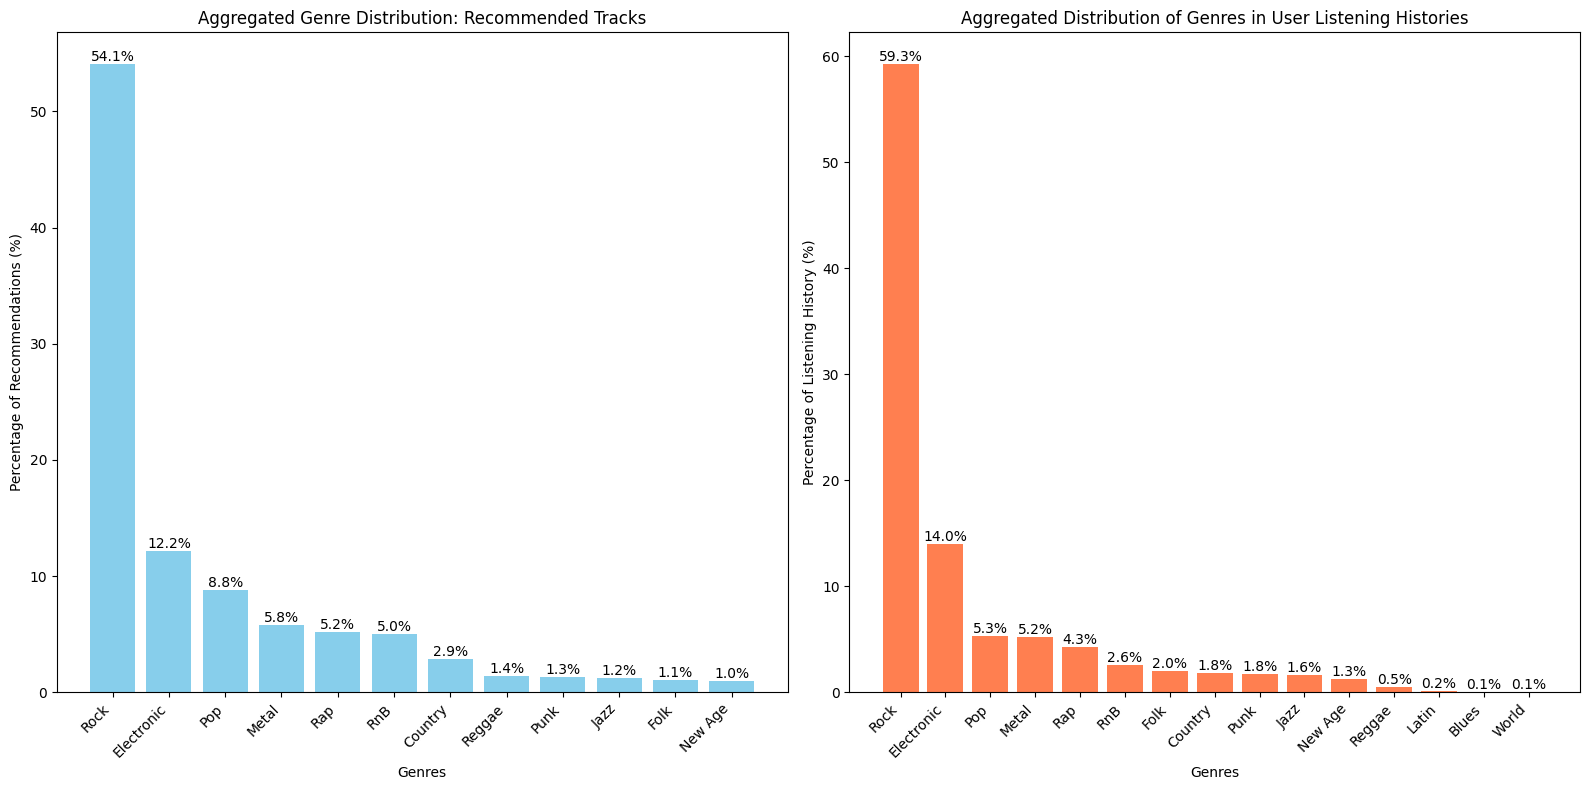

In [ ]:
plt.figure(figsize=(16, 8))

# Subplot 1: Recommended tracks genre distribution
plt.subplot(1, 2, 1)
bars = plt.bar(genre_counts_recommended.index, genre_counts_recommended.values, color='skyblue')
plt.xlabel("Genres")
plt.ylabel("Percentage of Recommendations (%)")
plt.title("Aggregated Genre Distribution: Recommended Tracks")
plt.xticks(rotation=45, ha='right')

# Percentage etiquettes to bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')

# Subplot 2: User listening history genre distribution
plt.subplot(1, 2, 2)
bars = plt.bar(genre_counts_history.index, genre_counts_history.values, color='coral')
plt.xlabel("Genres")
plt.ylabel("Percentage of Listening History (%)")
plt.title("Aggregated Distribution of Genres in User Listening Histories")
plt.xticks(rotation=45, ha='right')

# Percentage etiquettes to bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

The distribution appears very similar, which is a positive outcome. It is not identical, indicating that we are recommending new content to users. At the same time, it is not significantly different, which reassures us that the recommendations are not random.

However, the overall distribution may not reveal the full picture. To gain deeper insights, we will now analyze 10 random users by plotting their history and predictions.

In [ ]:

user_color = '#2ca02c'
recommendation_color = '#1f77b4'
genre_color = '#7f7f7f'

numerical_features = ['danceability', 'energy', 'speechiness',
                      'acousticness', 'instrumentalness', 'liveness',
                      'valence']
numerical_features2 = ['loudness', 'tempo', 'duration_s']



user_track_df = pd.read_csv("/content/drive/MyDrive/Spotify_Recommendation_Engine/PREPROCESSED_DATA/user_track_recommendations.csv")

random_users = user_track_df['user_id'].dropna().sample(n=10, random_state=42).tolist()


In [ ]:

# Function to plot user vs recommendation stats
def plot_user_vs_recommendation_stats_with_percentages(user_id, recommendations_df, numerical_features, numerical_features2):
    """
    Plot comparison of track stats for tracks the user has already listened to vs. recommended tracks.
    Show percentage distribution of playcounts per genre and artist for user history and recommendations.
    """
    # Get the user's listening history
    user_history = listening_history_df[listening_history_df['user_id'] == user_id].merge(tracks_df, on='track_id')

    # Calculate average values for numerical features
    user_history_avg = user_history[numerical_features].mean()
    recommendations_avg = recommendations_df[numerical_features].mean()

    # Calculate genre and artist percentage distributions for user history
    genre_percentage_user = user_history.groupby('genre')['playcount'].sum() / user_history['playcount'].sum() * 100
    genre_percentage_recommendations = recommendations_df['genre'].value_counts(normalize=True) * 100

    # Plot overall numerical feature comparison
    stats_df = pd.DataFrame({
        'User History': user_history_avg,
        'Recommendations': recommendations_avg
    })

    plt.figure(figsize=(14, 8))
    stats_df.plot(kind='bar', color=[user_color, recommendation_color], figsize=(14, 8))
    plt.title(f"Comparison of Track Stats for User {user_id}\n(User History vs. Recommendations)", fontsize=16)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Average Value", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.legend(title="Track Data", fontsize=10)
    plt.tight_layout()
    plt.show()

    # Plot numerical_features2 on one plot
    user_history_features2 = user_history[numerical_features2].mean()
    recommendations_features2 = recommendations_df[numerical_features2].mean()

    feature_comparison_df = pd.DataFrame({
        'User History': user_history_features2,
        'Recommendations': recommendations_features2
    })

    feature_comparison_df.plot(kind='bar', color=[user_color, recommendation_color], figsize=(12, 6))
    plt.title(f"Comparison of Selected Features for User {user_id}", fontsize=16)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Average Value", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.legend(title="Track Data", fontsize=10)
    plt.tight_layout()
    plt.show()

    # Plot Genre Distribution
    plt.figure(figsize=(12, 8))
    plt.bar(genre_percentage_user.index, genre_percentage_user.values, color=genre_color, alpha=0.7, label='User History')
    plt.bar(genre_percentage_recommendations.index, genre_percentage_recommendations.values, color='green', alpha=0.5, label='Recommendations')
    plt.xlabel("Genres", fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.title(f"Genre Distribution for User {user_id}", fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.legend(title="Genres", fontsize=10)
    plt.tight_layout()
    plt.show()


<Figure size 1400x800 with 0 Axes>

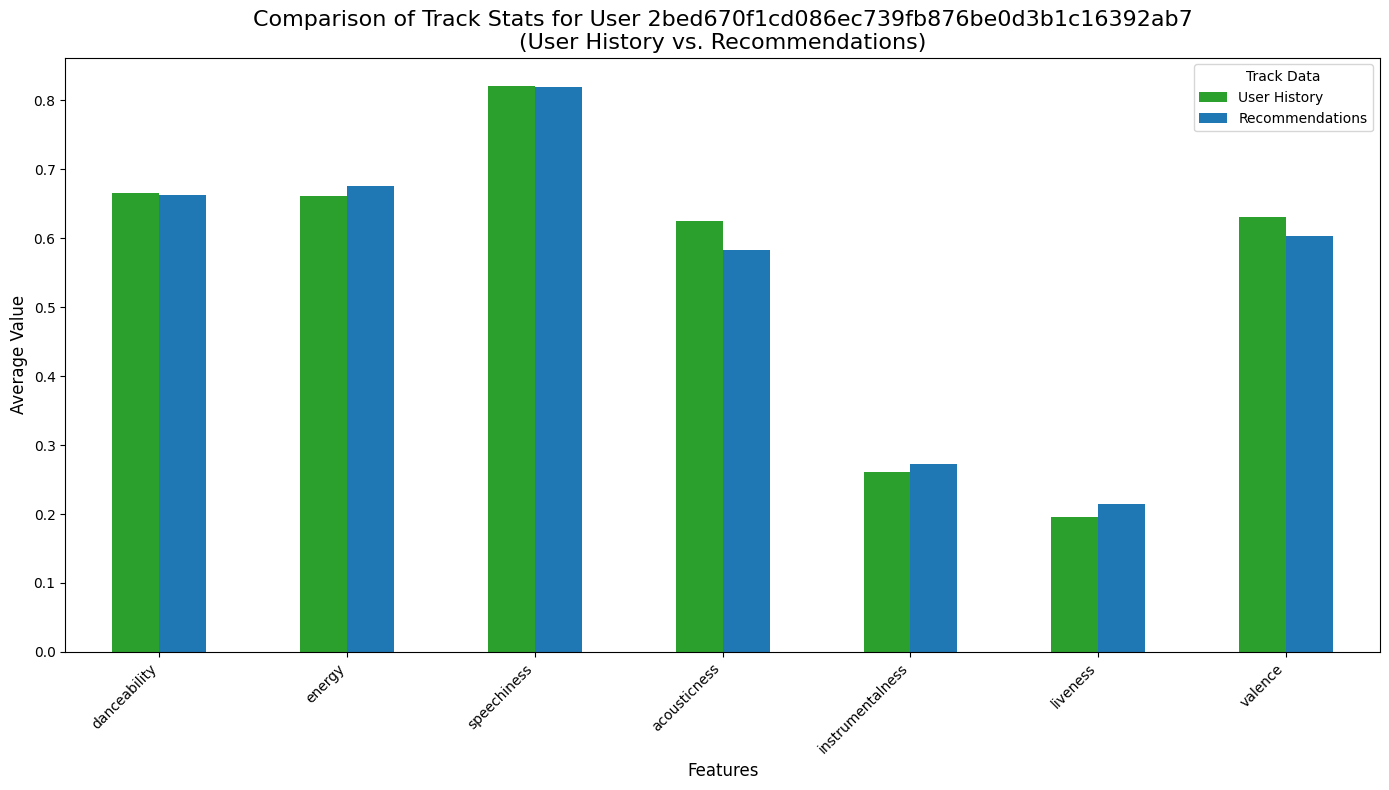

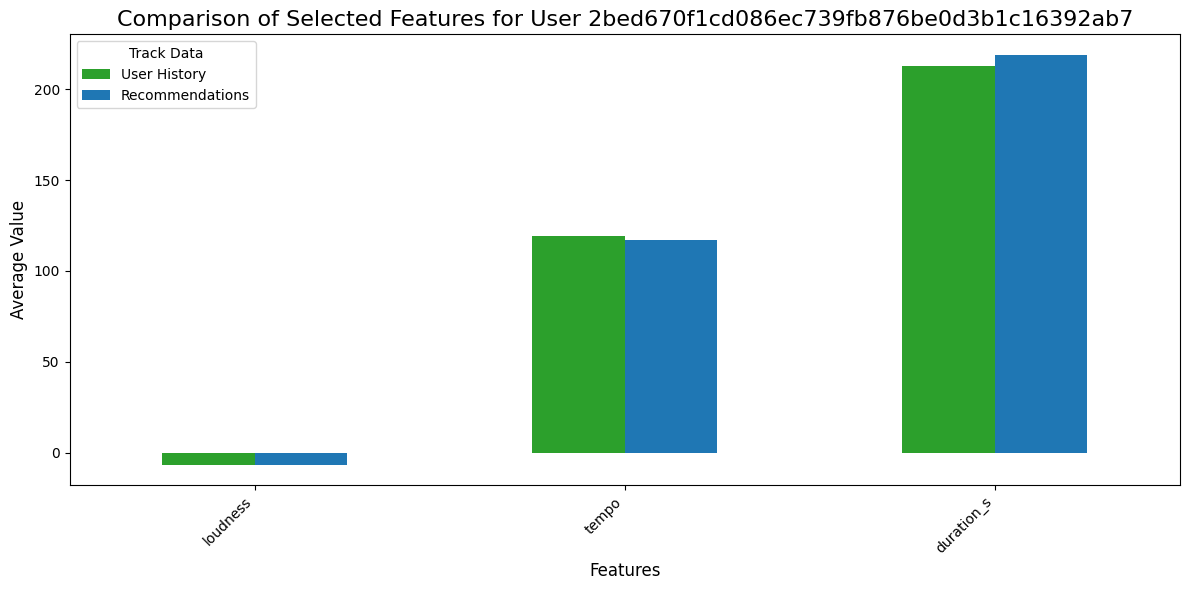

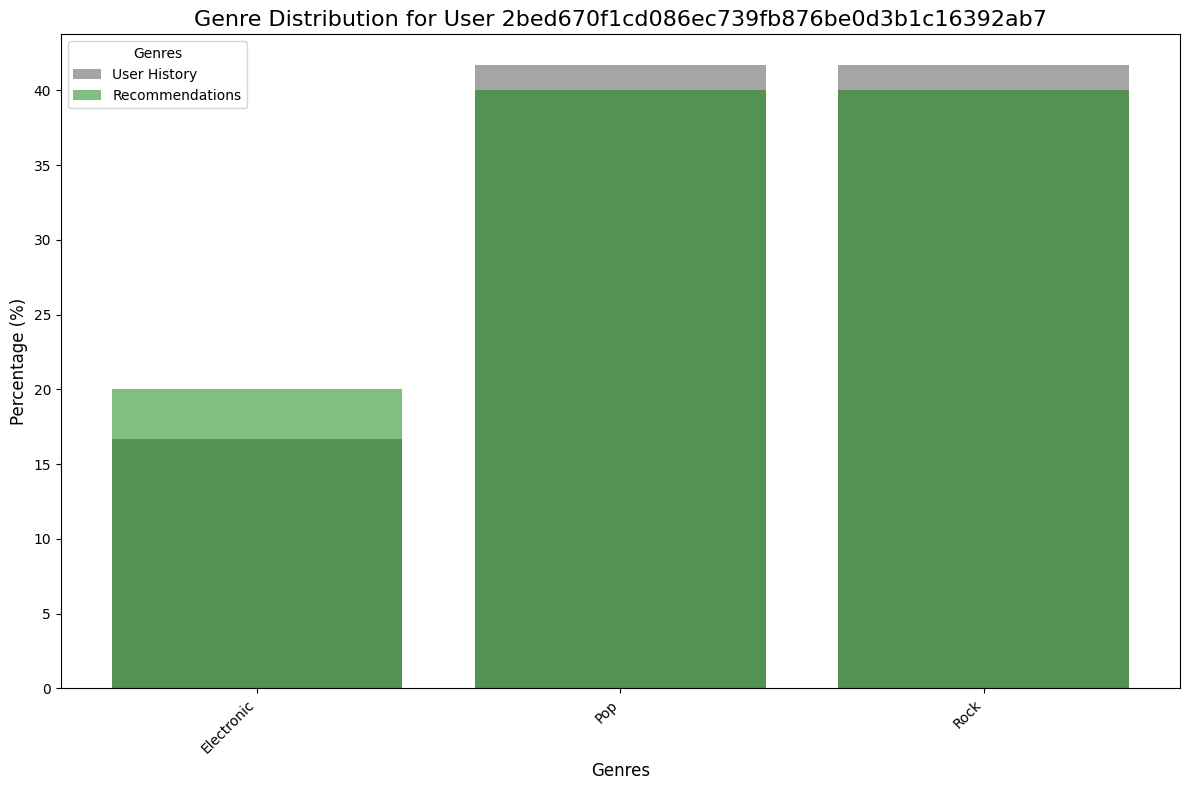

<Figure size 1400x800 with 0 Axes>

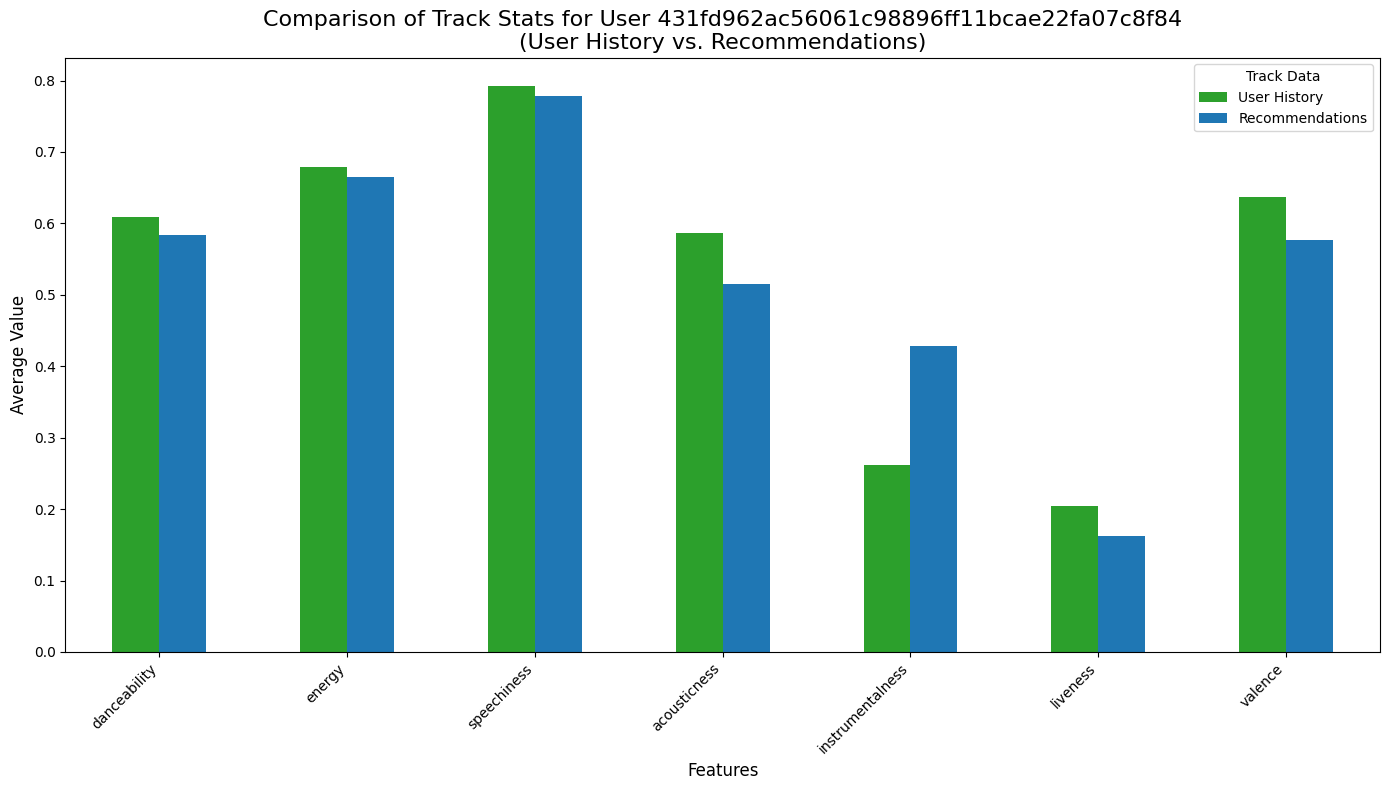

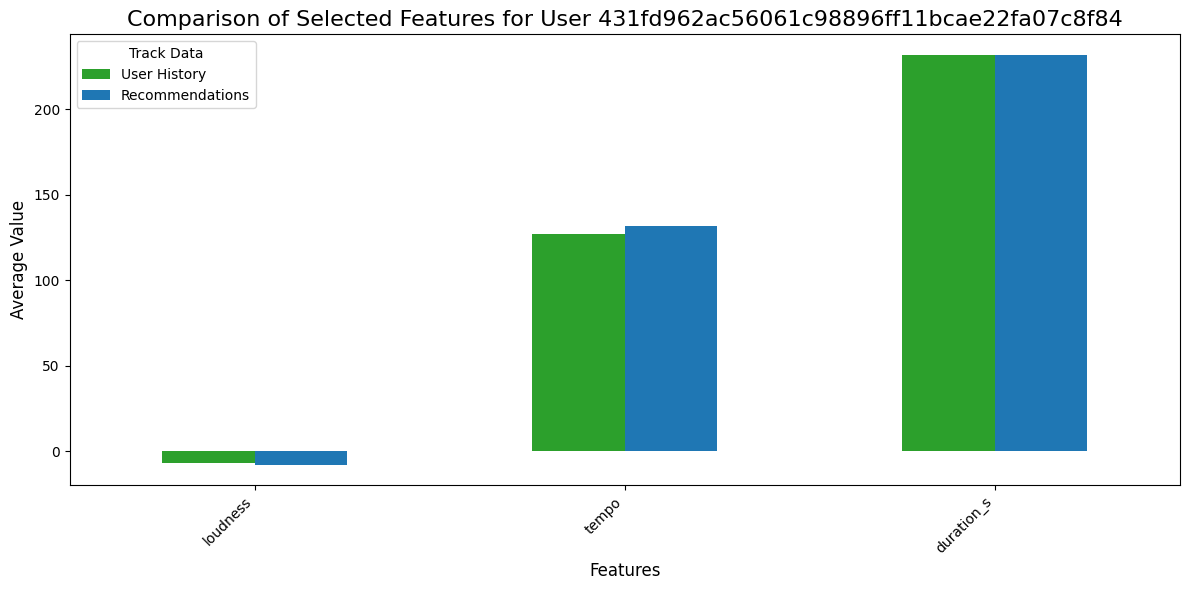

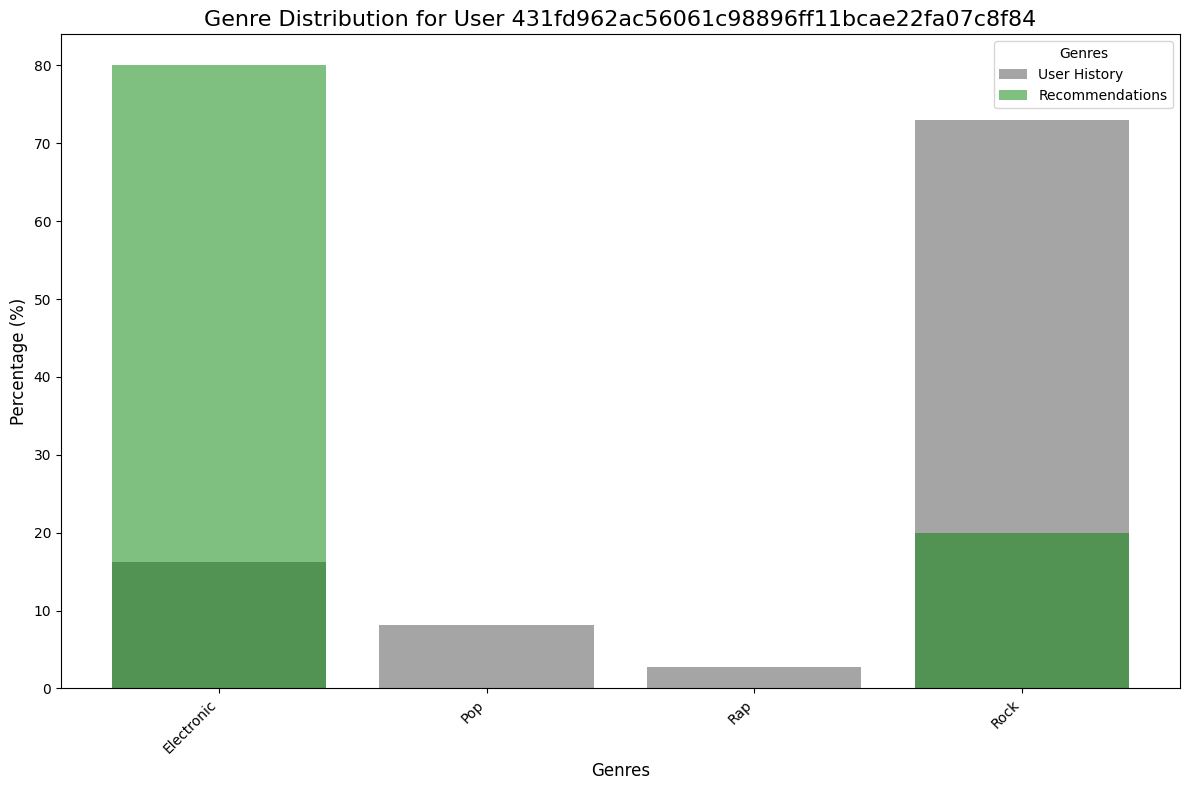

<Figure size 1400x800 with 0 Axes>

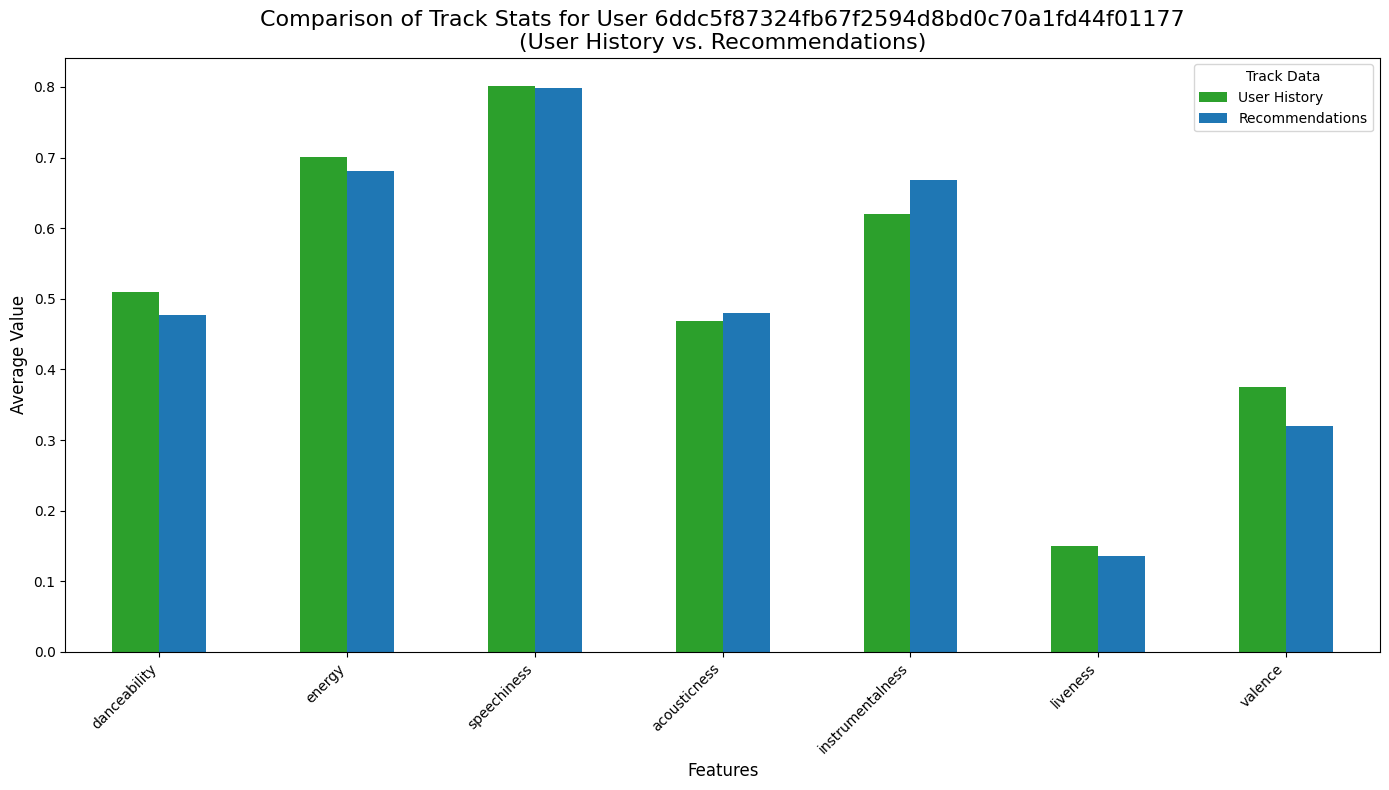

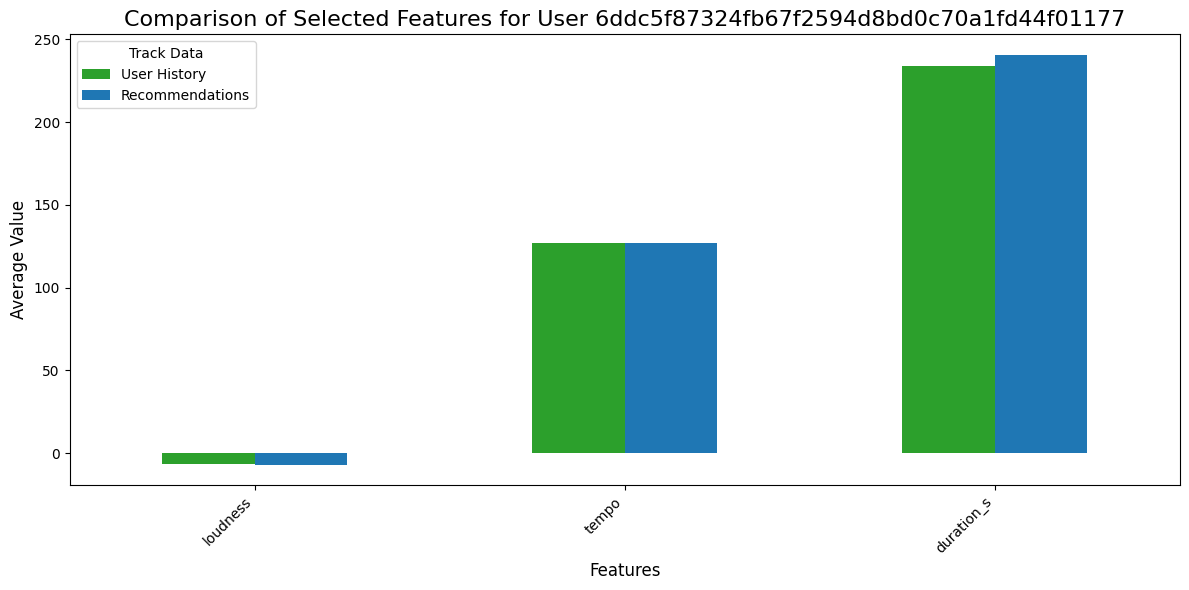

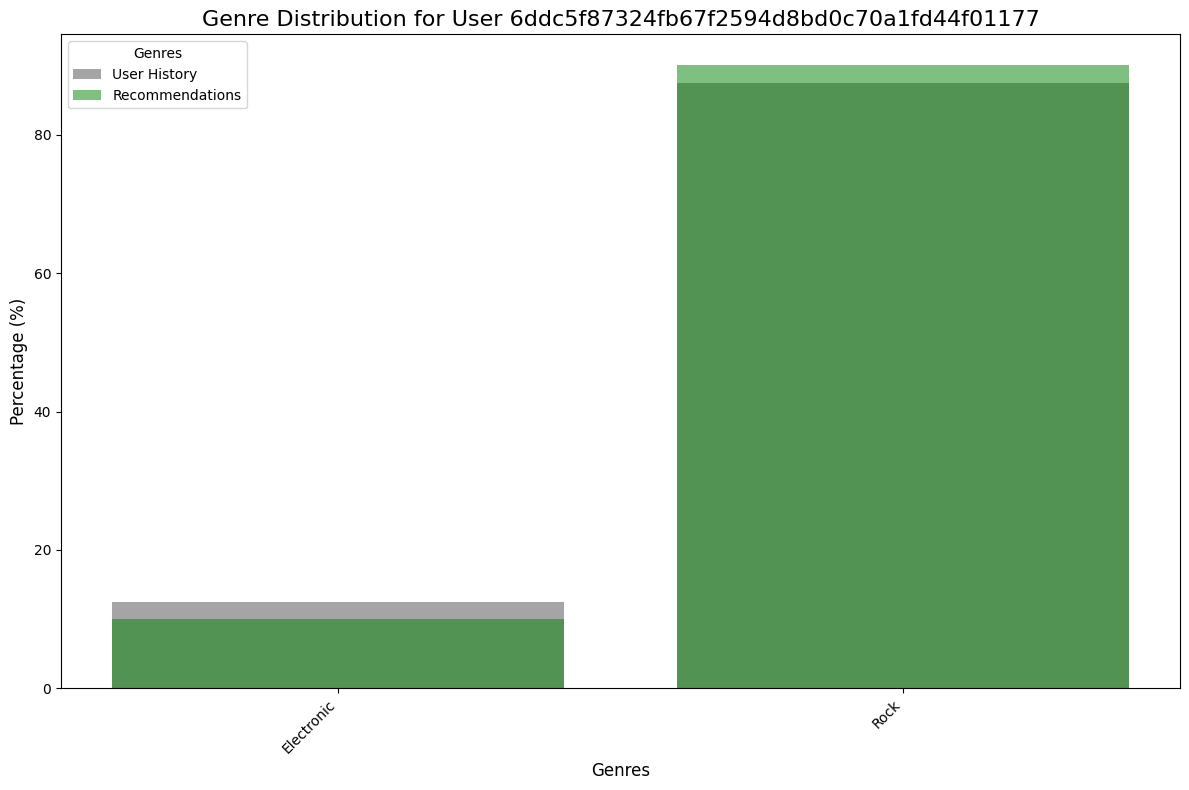

<Figure size 1400x800 with 0 Axes>

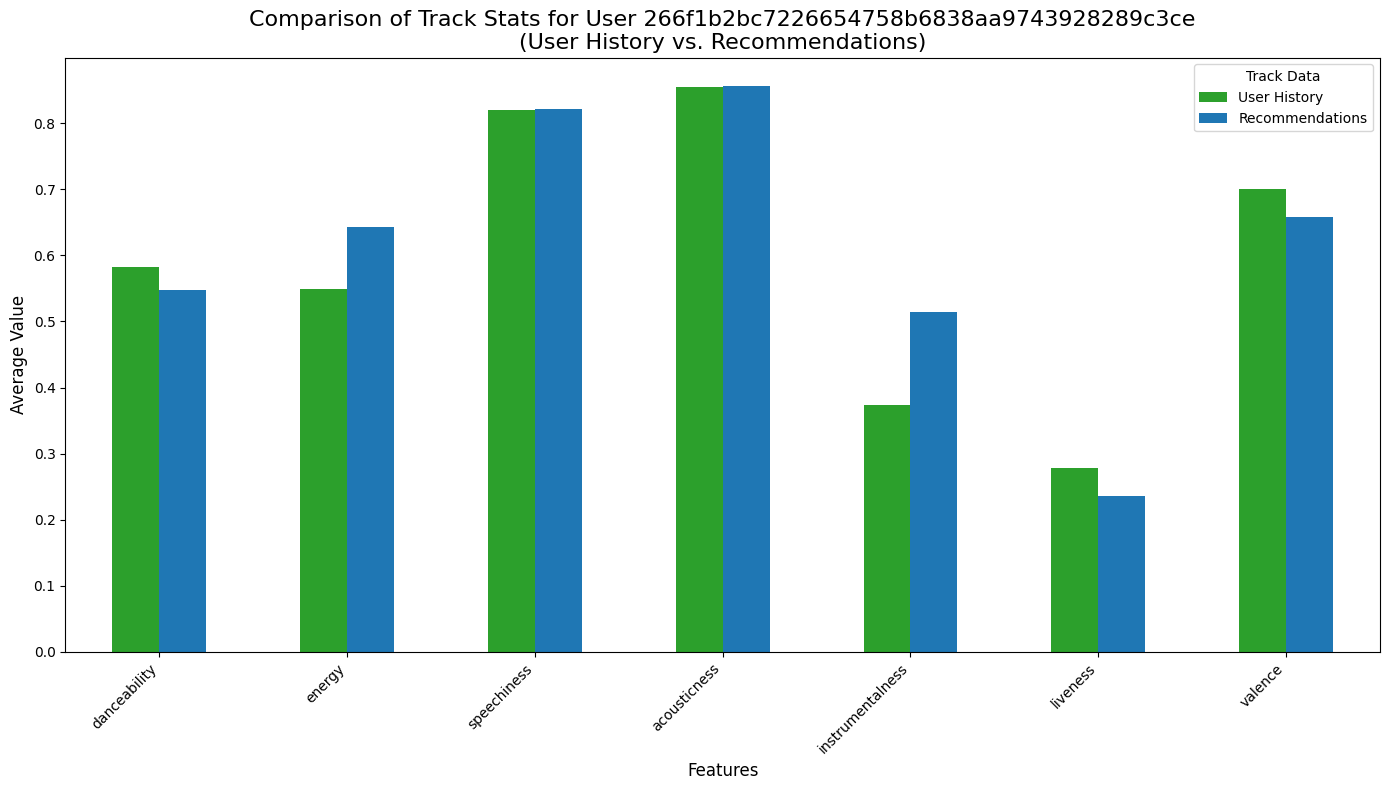

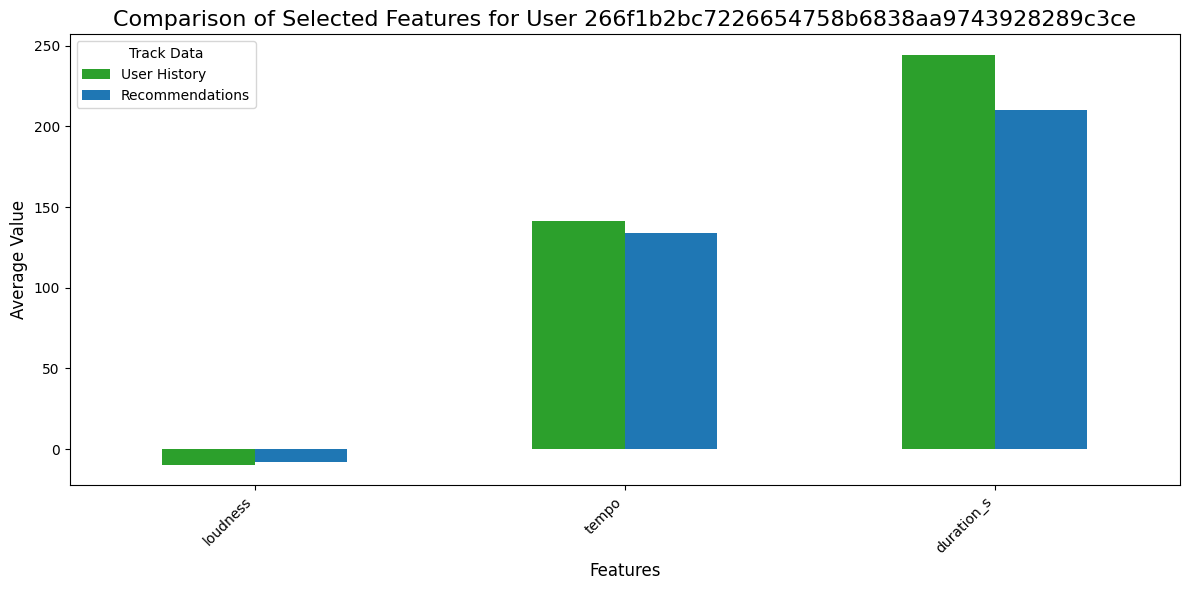

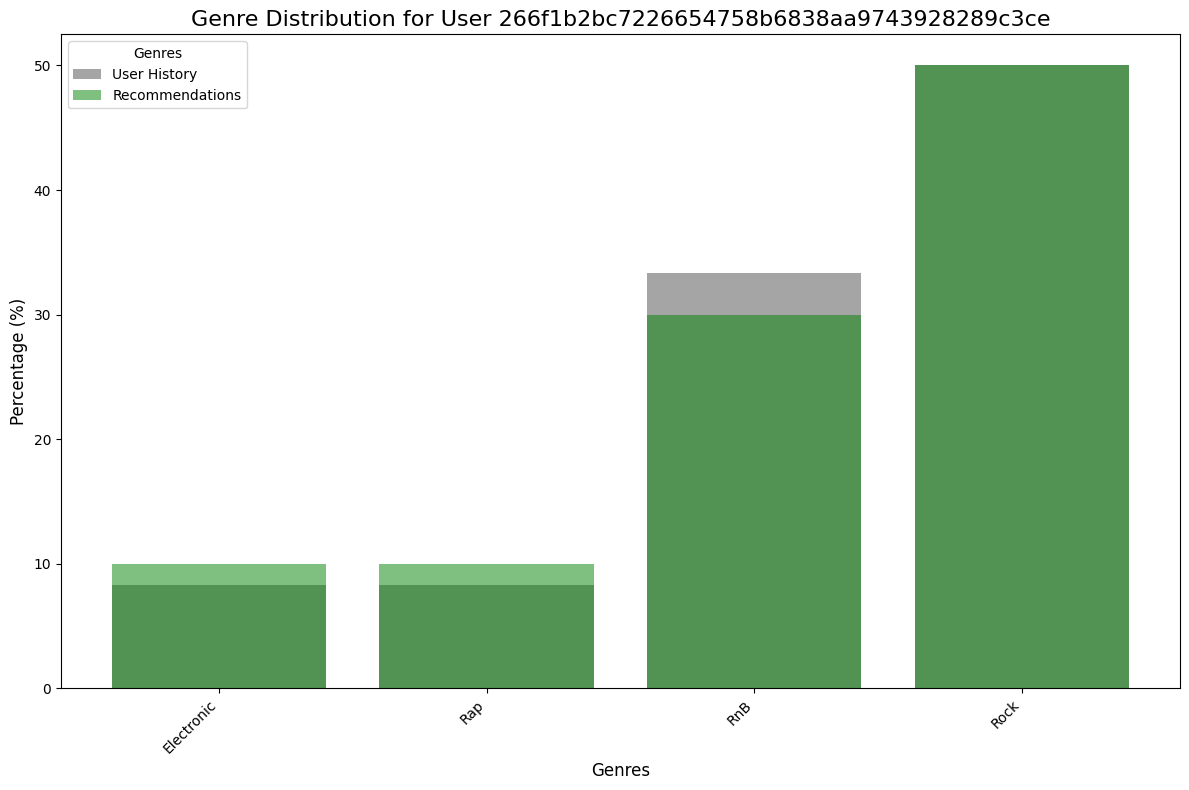

<Figure size 1400x800 with 0 Axes>

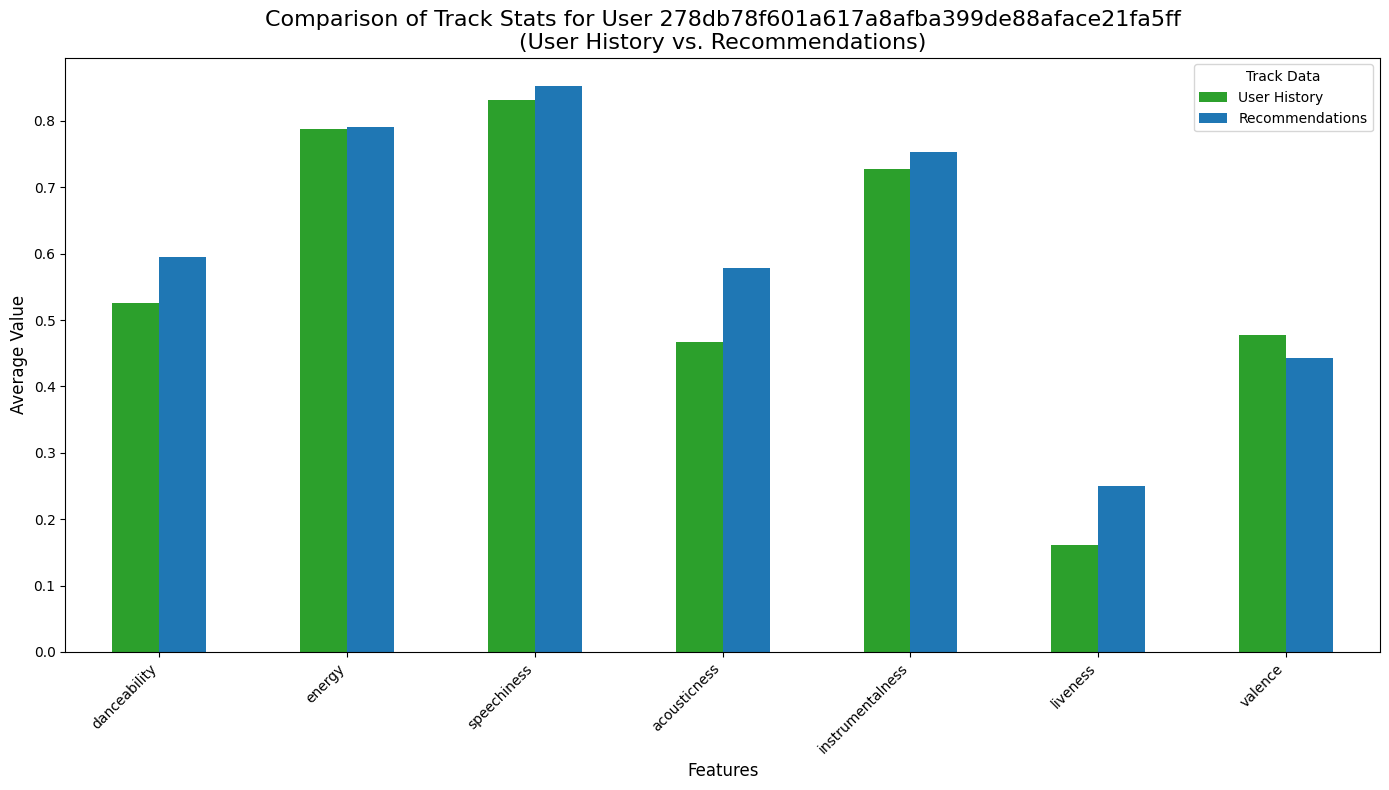

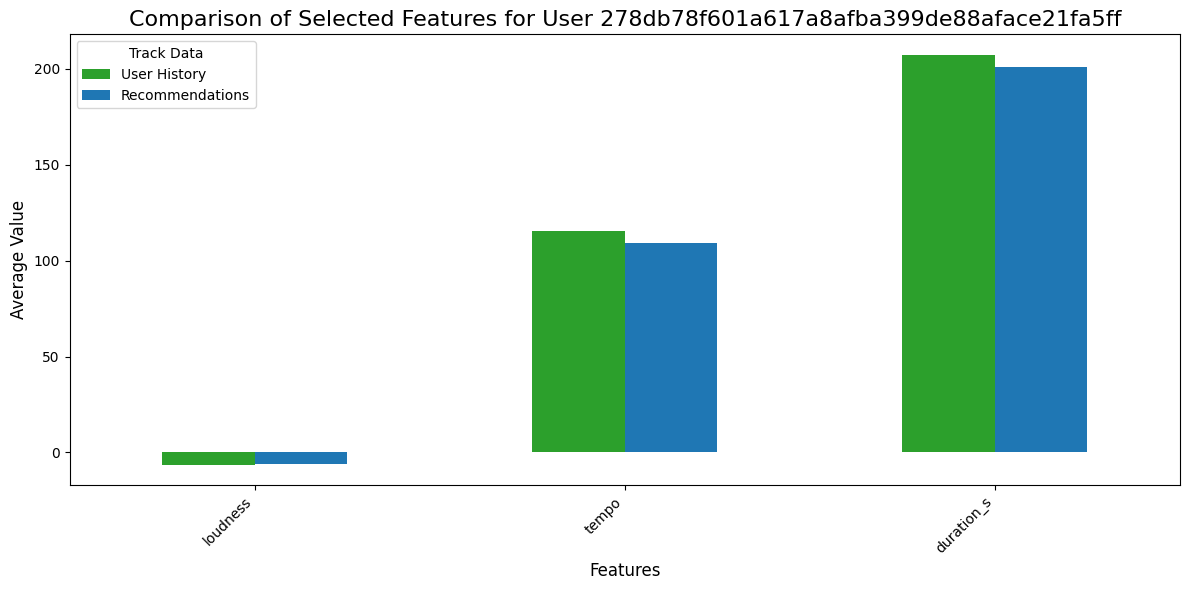

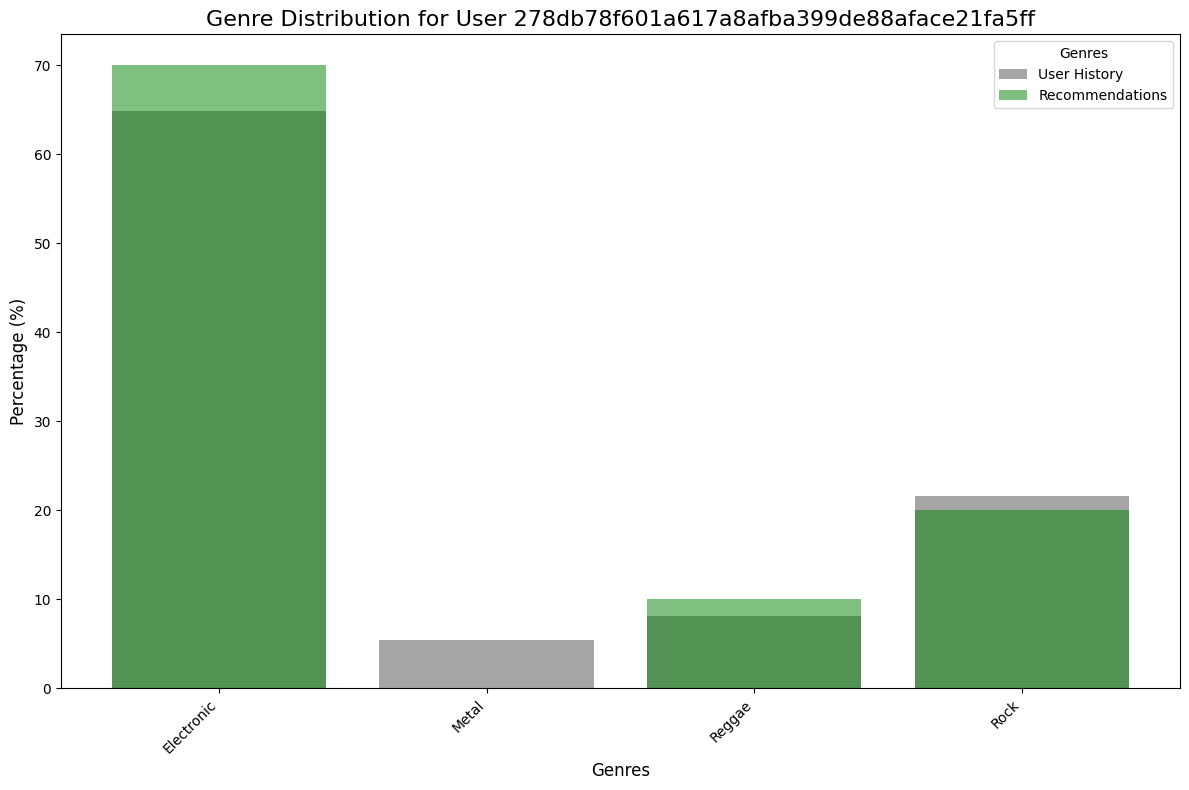

<Figure size 1400x800 with 0 Axes>

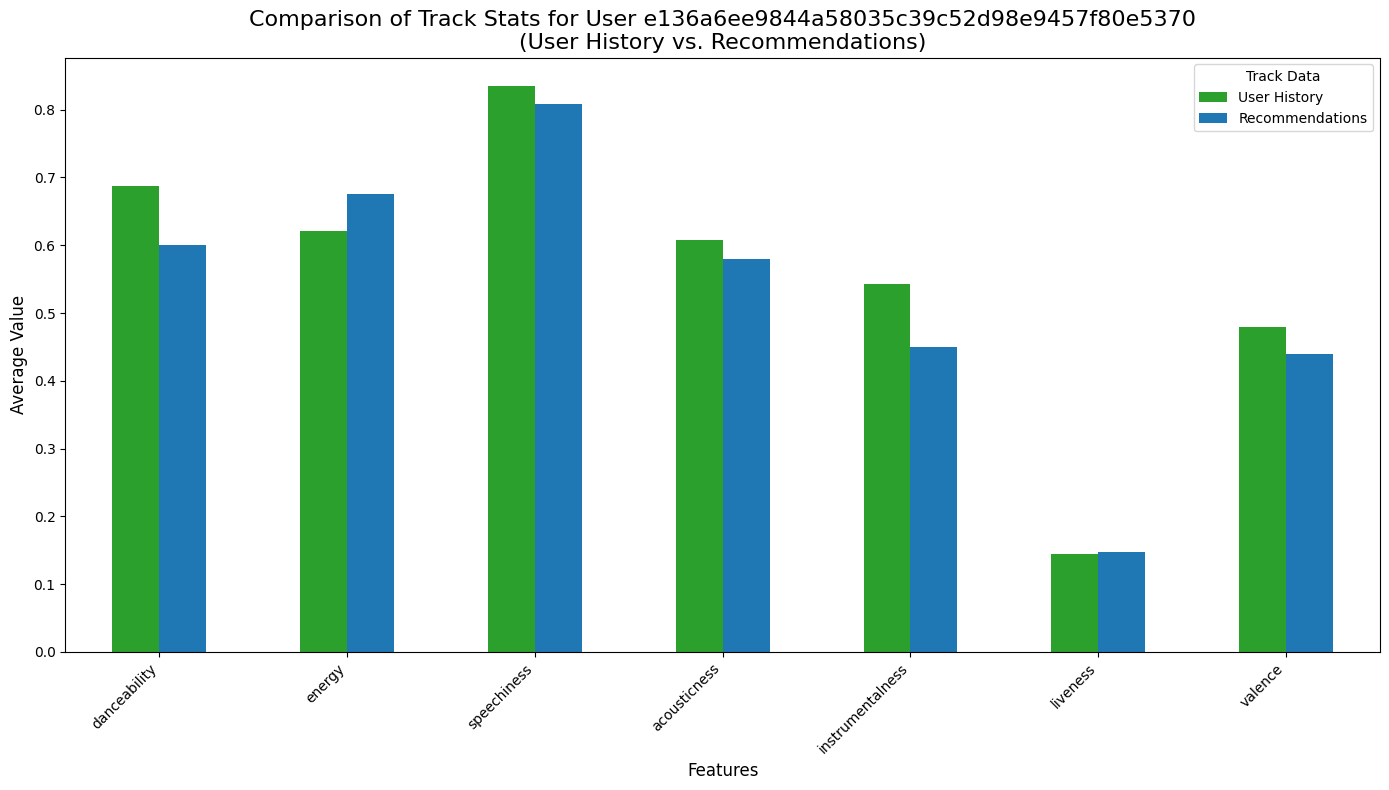

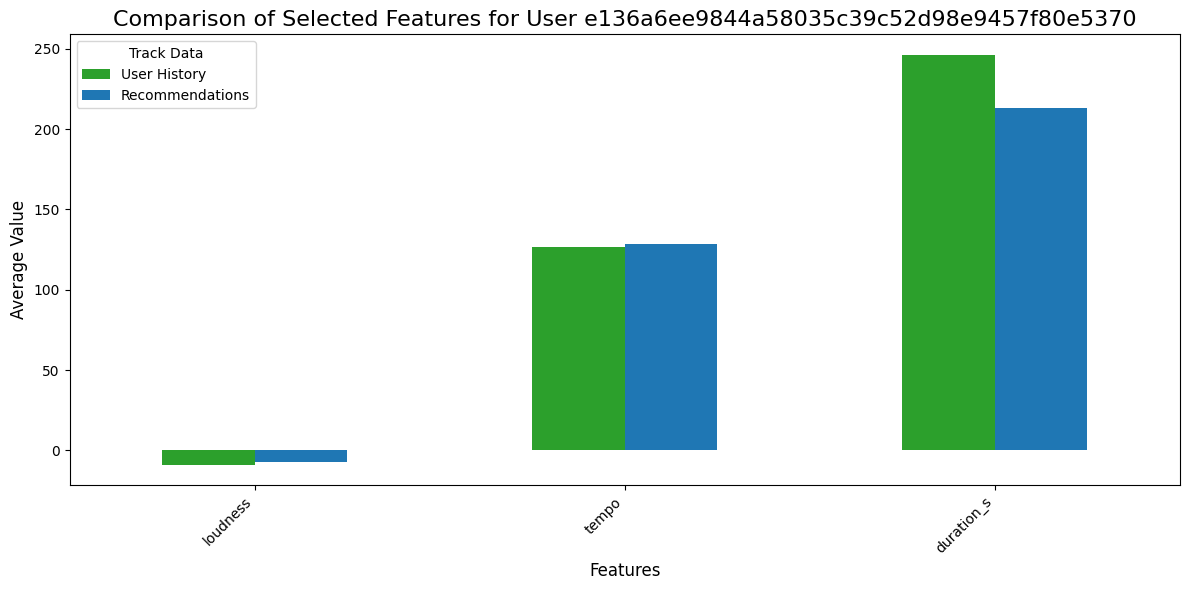

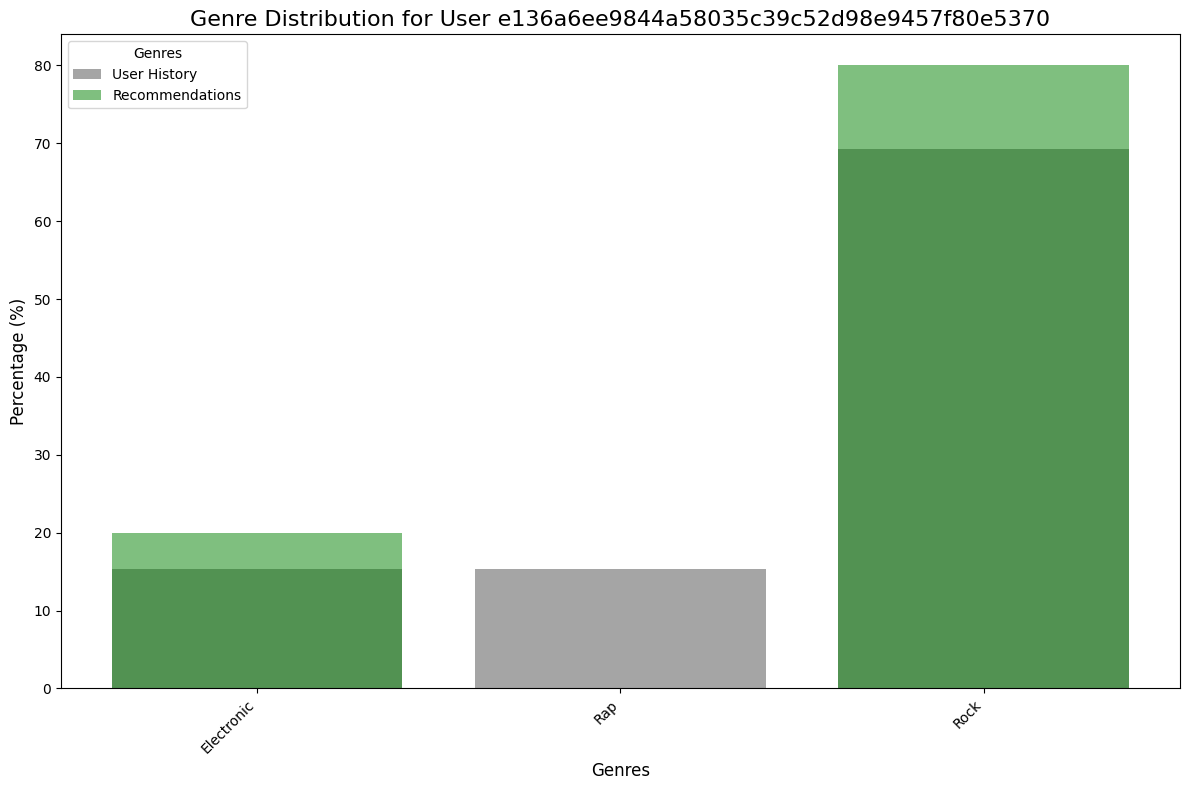

<Figure size 1400x800 with 0 Axes>

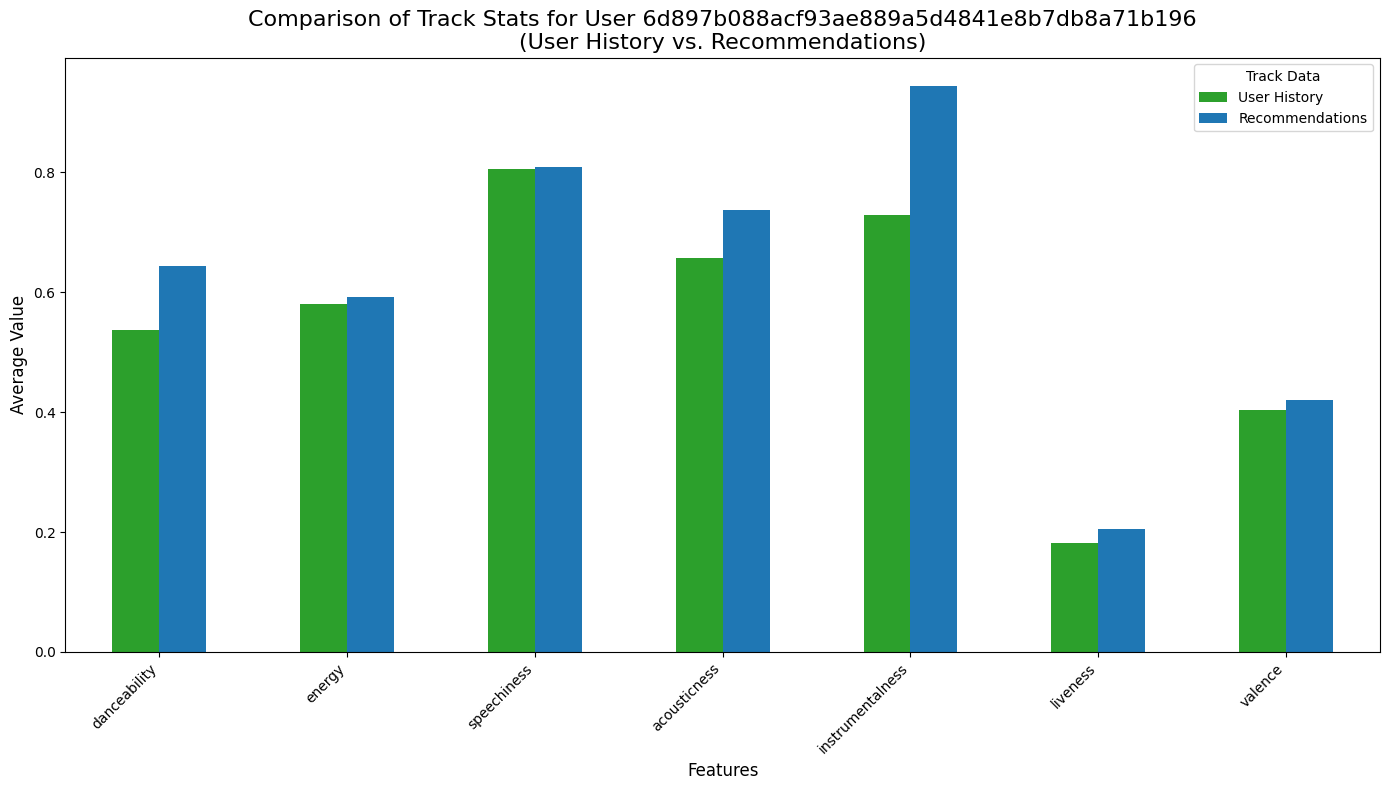

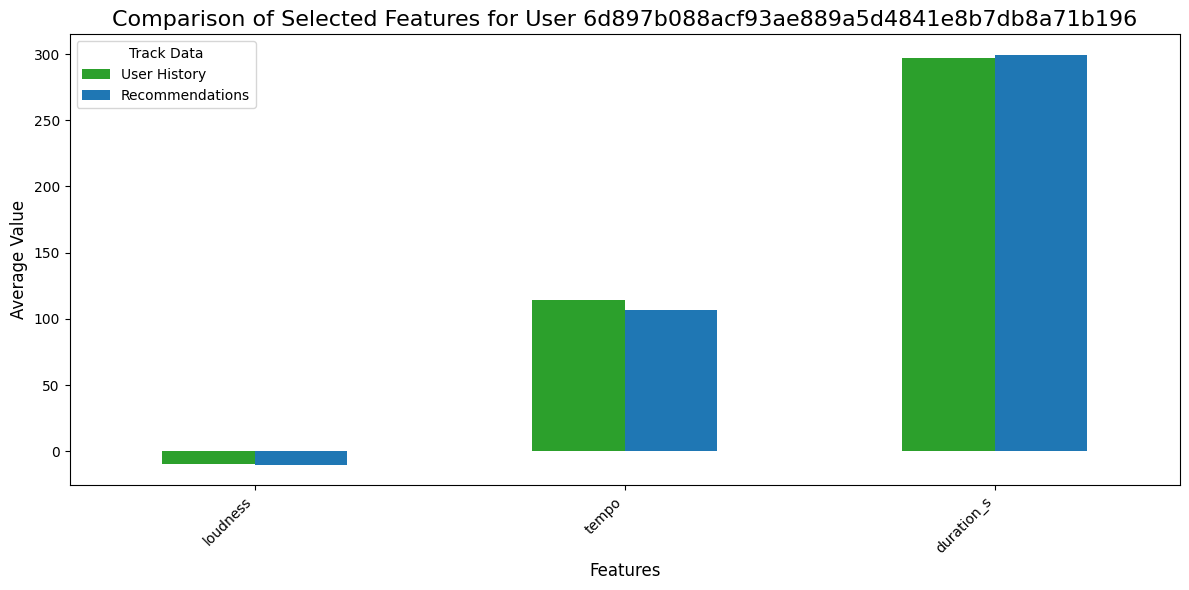

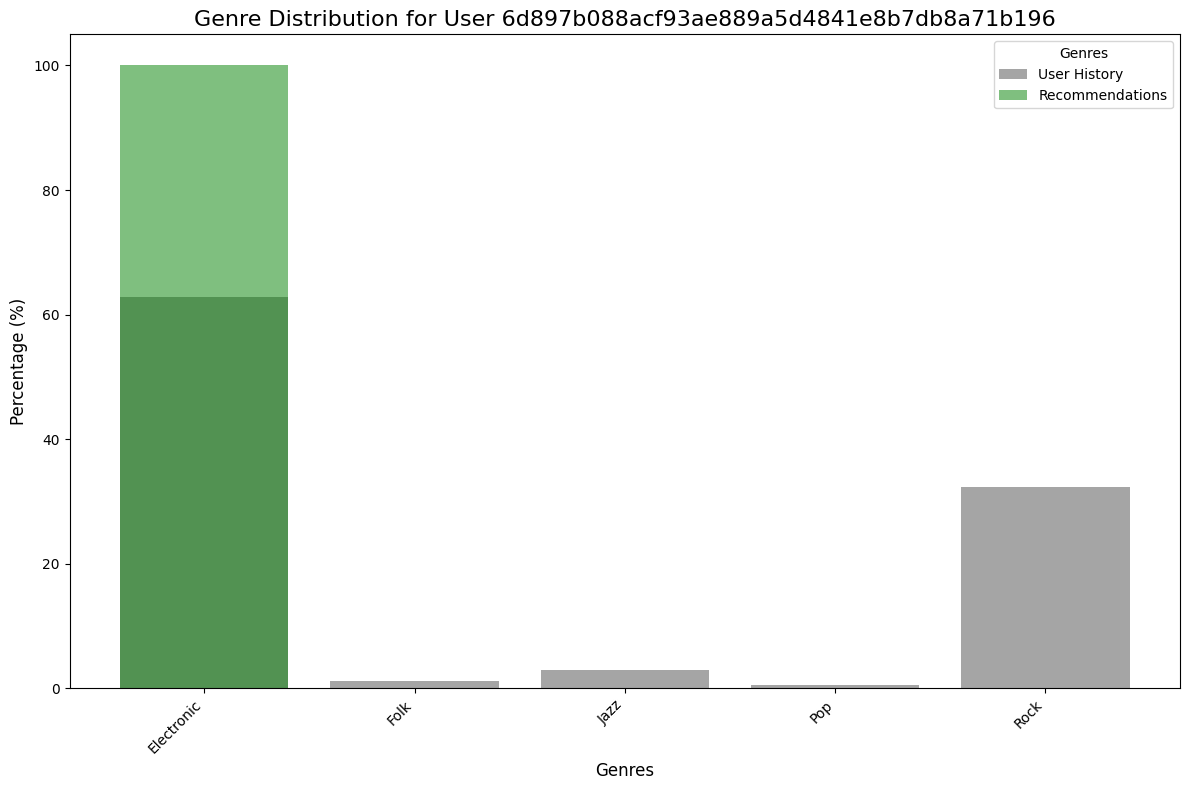

<Figure size 1400x800 with 0 Axes>

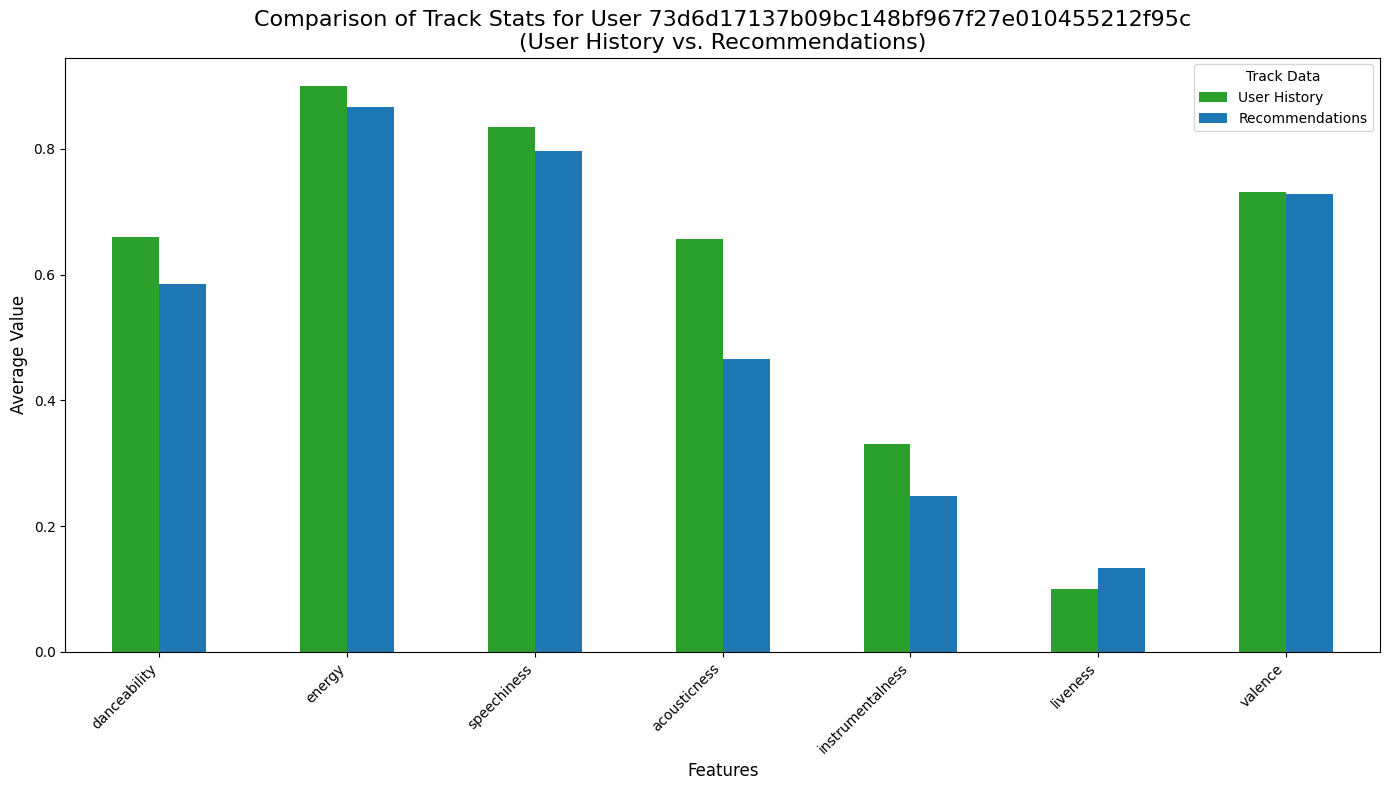

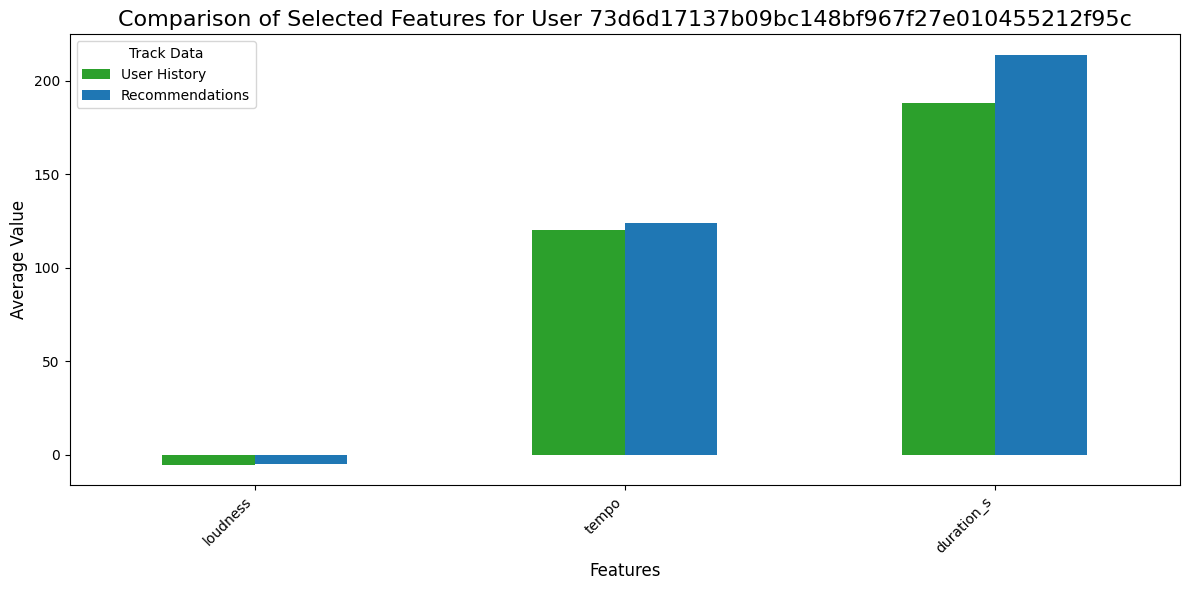

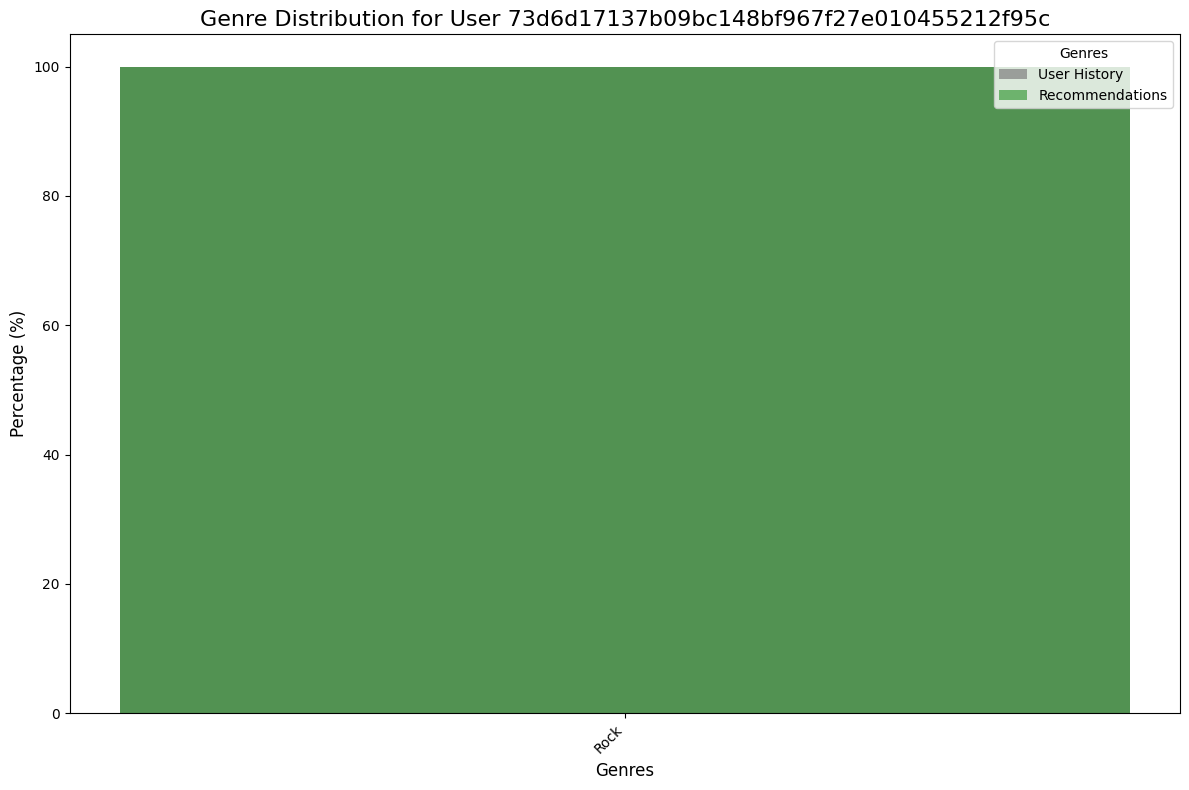

<Figure size 1400x800 with 0 Axes>

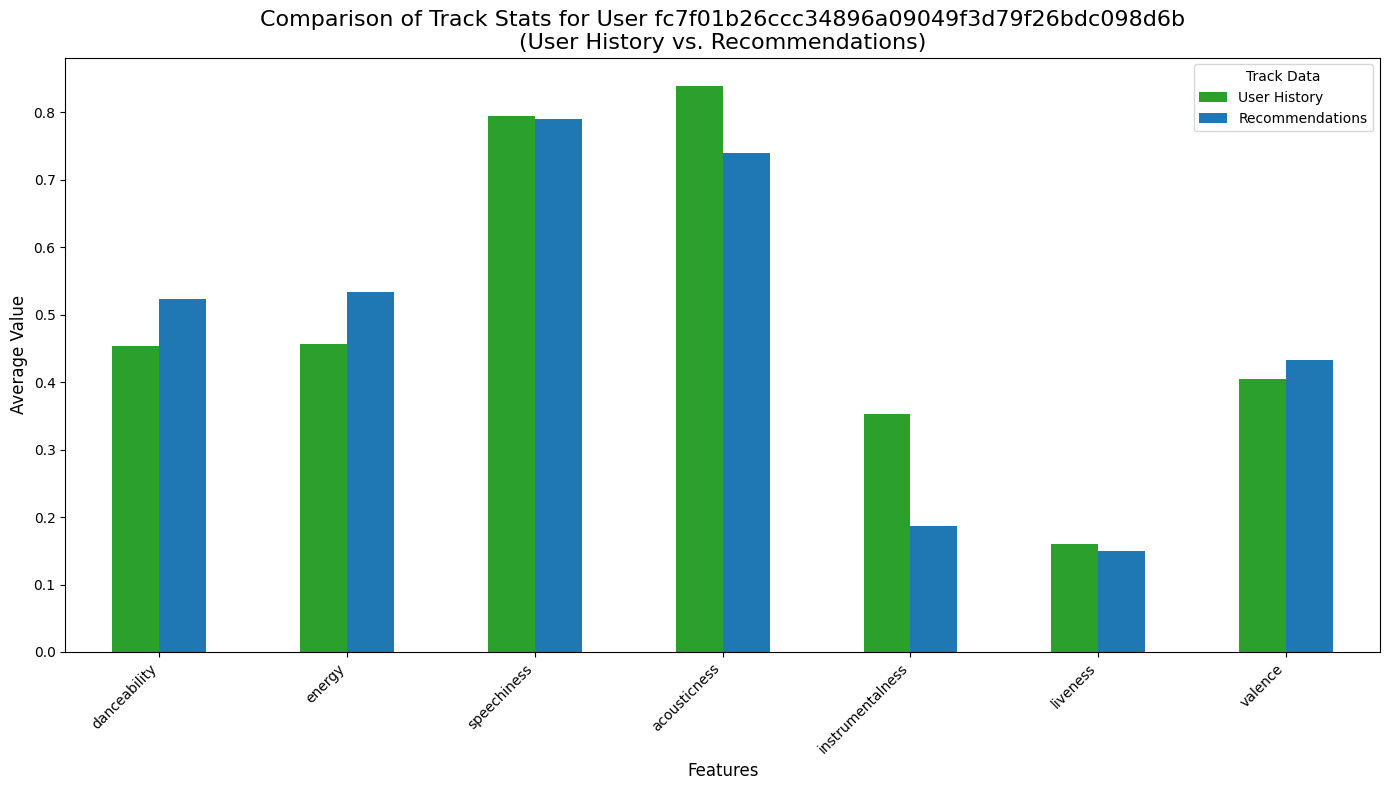

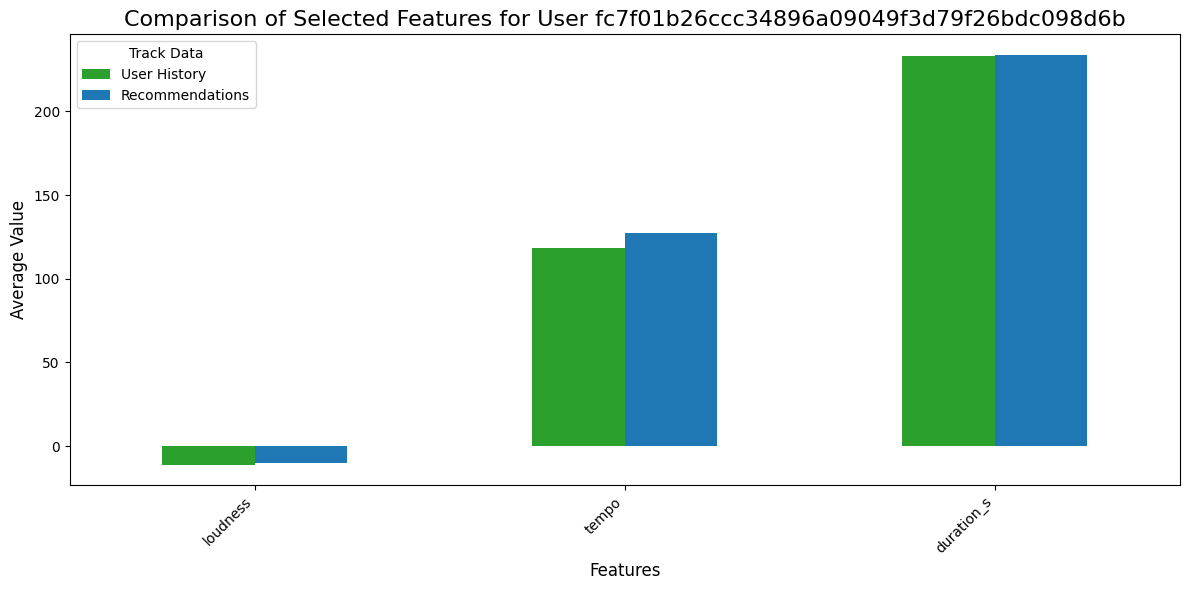

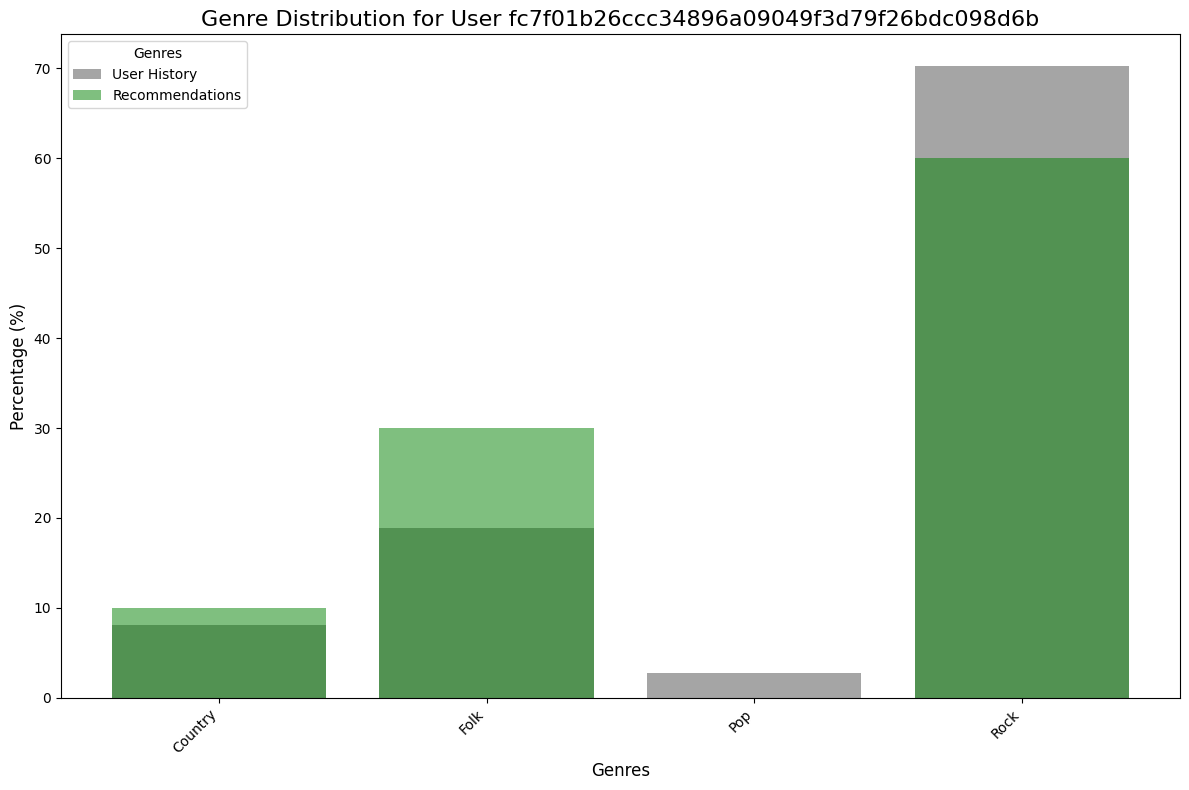

<Figure size 1400x800 with 0 Axes>

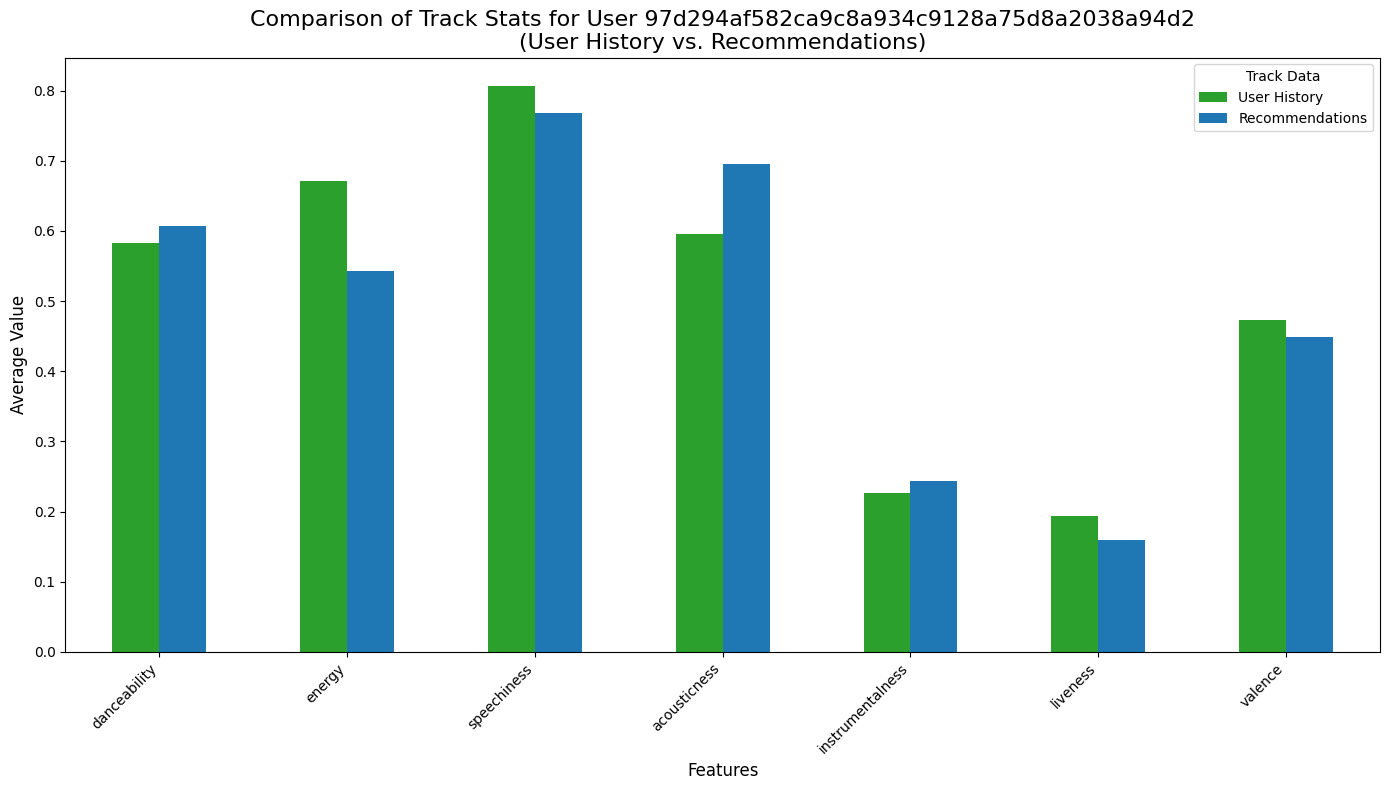

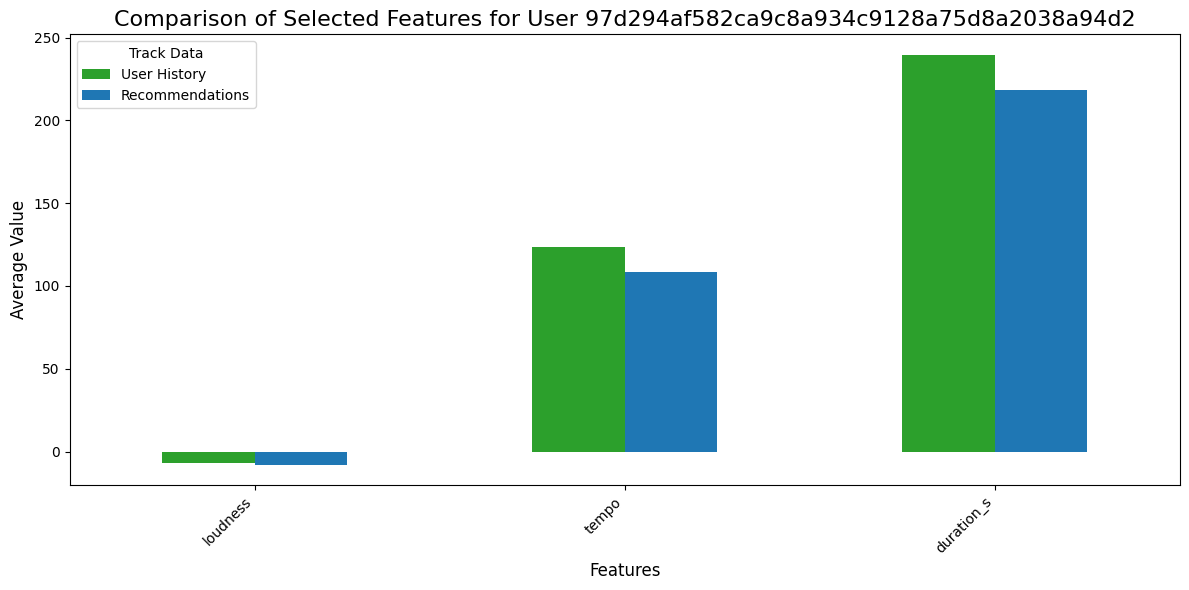

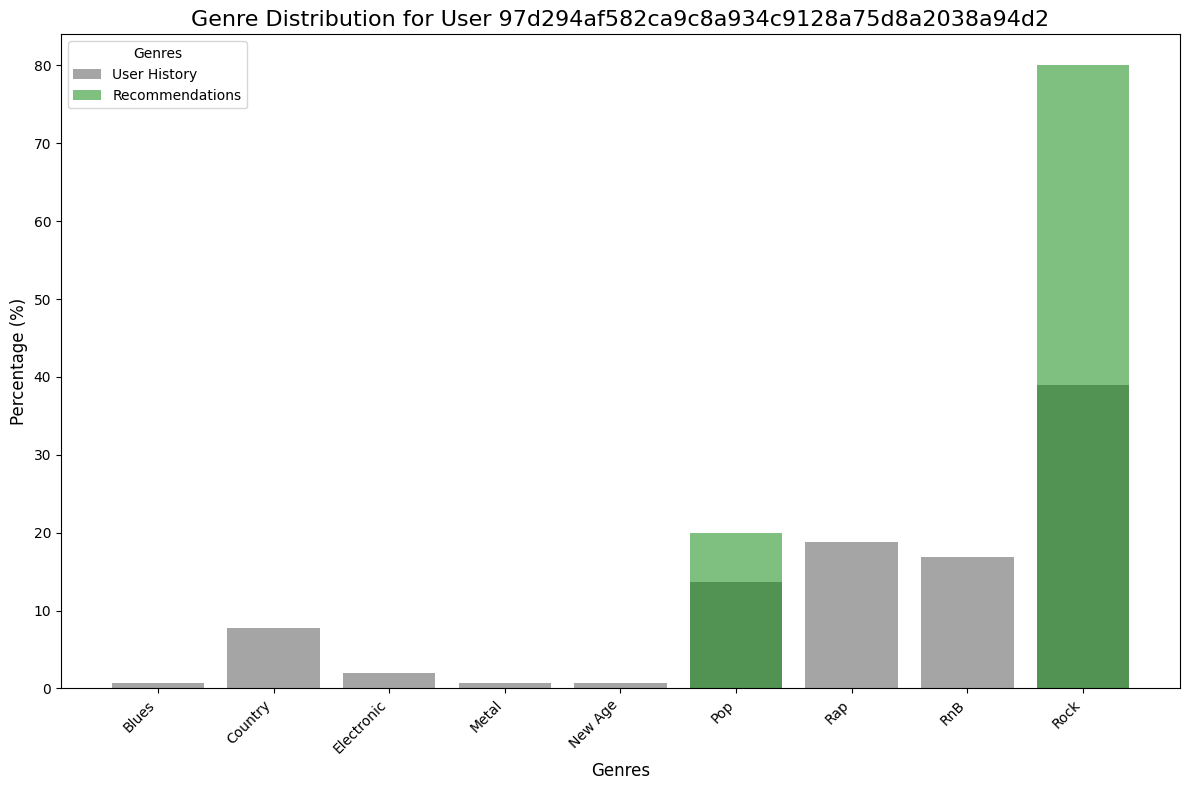

In [ ]:
for user_id in random_users:
    # Get recommended tracks for the user from the saved CSV
    recommended_track_ids = user_track_df[user_track_df['user_id'] == user_id]['track_id'].tolist()
    recommendations_df = tracks_df[tracks_df['track_id'].isin(recommended_track_ids)]


    # Generate plots for the user
    plot_user_vs_recommendation_stats_with_percentages(user_id, recommendations_df, numerical_features, numerical_features2)


These recommendations look good. Keep in mind that the main factors driving our recommendations were numerical features, which is clearly reflected here.

The changes in the distribution of numerical features are minor.

However, when we look at the genre distribution, it might seem nonsensical at first. This is because the numerical features of different genres often overlap to some extent. As a result, tracks can have identical numerical features but belong to different genres.
